# Comparing negative binomial and normal linear regression models

The goal of this notebook is to compare negative binomial and normal models of real CRISPR-screen data.
Comparisons will be made on computational efficiency, MCMC diagnositics, model accuracy and fitness, and posterior predictive checks.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import pprint
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
from src.analysis import pymc3_analysis as pmanal
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.data_processing import vectors as vhelp
from src.globals import PYMC3
from src.io import cache_io, data_io
from src.loggers import set_console_handler_level
from src.modeling import pymc3_helpers as pmhelp
from src.modeling import pymc3_sampling_api as pmapi
from src.plot.color_pal import SeabornColor

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)
set_console_handler_level(logging.WARN)

gg.theme_set(
    gg.theme_classic()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
        panel_grid_major_y=gg.element_line(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 212
np.random.seed(RANDOM_SEED)

## Data

In [6]:
crc_subsample_modeling_data_path = data_io.data_path(
    data_io.DataFile.DEPMAP_CRC_SUBSAMPLE
)
crc_subsample_modeling_data = achelp.read_achilles_data(
    crc_subsample_modeling_data_path, low_memory=False, set_categorical_cols=True
)
crc_subsample_modeling_data.head()

sgrna                       replicate_id       lfc  \
0  ATAACACTGCACCTTCCAAC       LS513-311Cas9_RepA_p6_batch2  0.179367   
1  ATAACACTGCACCTTCCAAC       CL-11-311Cas9_RepB_p6_batch3 -0.139505   
2  ATAACACTGCACCTTCCAAC     SW1463-311cas9 Rep A p5_batch2 -0.192216   
3  ATAACACTGCACCTTCCAAC  HT29-311Cas9_RepA_p6 AVANA_batch3  0.282499   
4  ATAACACTGCACCTTCCAAC       KM12-311Cas9 Rep A p5_batch3  0.253698   

  p_dna_batch  genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0           2  chr2_157587191_-      ACVR1C  broad                   True   
1           3  chr2_157587191_-      ACVR1C  broad                  False   
2           2  chr2_157587191_-      ACVR1C  broad                   True   
3           3  chr2_157587191_-      ACVR1C  broad                   True   
4           3  chr2_157587191_-      ACVR1C  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... num_mutations  any_deleterious  \
0                2         157587191  ...             0              NaN   
1                2         157587191  ...             0              NaN   
2                2         157587191  ...             0              NaN   
3                2         157587191  ...             0              NaN   
4                2         157587191  ...             0              NaN   

   any_tcga_hotspot  any_cosmic_hotspot  is_mutated copy_number     lineage  \
0               NaN                 NaN       False    0.964254  colorectal   
1               NaN                 NaN       False    1.004888  colorectal   
2               NaN                 NaN       False    0.923384  colorectal   
3               NaN                 NaN       False    1.014253  colorectal   
4               NaN                 NaN       False    1.048861  colorectal   

  primary_or_metastasis  is_male   age  
0               primary     True  63.0  
1               primary     True   NaN  
2               primary    False  66.0  
3               primary    False  44.0  
4               primary      NaN   NaN  

[5 rows x 24 columns]

In [7]:
crc_subsample_modeling_data.columns.to_list()

['sgrna',
 'replicate_id',
 'lfc',
 'p_dna_batch',
 'genome_alignment',
 'hugo_symbol',
 'screen',
 'multiple_hits_on_gene',
 'sgrna_target_chr',
 'sgrna_target_pos',
 'depmap_id',
 'counts_final',
 'counts_initial',
 'rna_expr',
 'num_mutations',
 'any_deleterious',
 'any_tcga_hotspot',
 'any_cosmic_hotspot',
 'is_mutated',
 'copy_number',
 'lineage',
 'primary_or_metastasis',
 'is_male',
 'age']

In [8]:
data = (
    crc_subsample_modeling_data[~crc_subsample_modeling_data.counts_final.isna()]
    .reset_index(drop=True)
    .pipe(achelp.set_achilles_categorical_columns)
    .astype({"counts_final": int, "counts_initial": int})
    .reset_index(drop=True)
    .shuffle()
    .pipe(
        achelp.zscale_cna_by_group,
        cn_col="copy_number",
        new_col="copy_number_z",
        groupby_cols=["depmap_id"],
        cn_max=20,
    )
)
data.shape

(2384, 25)

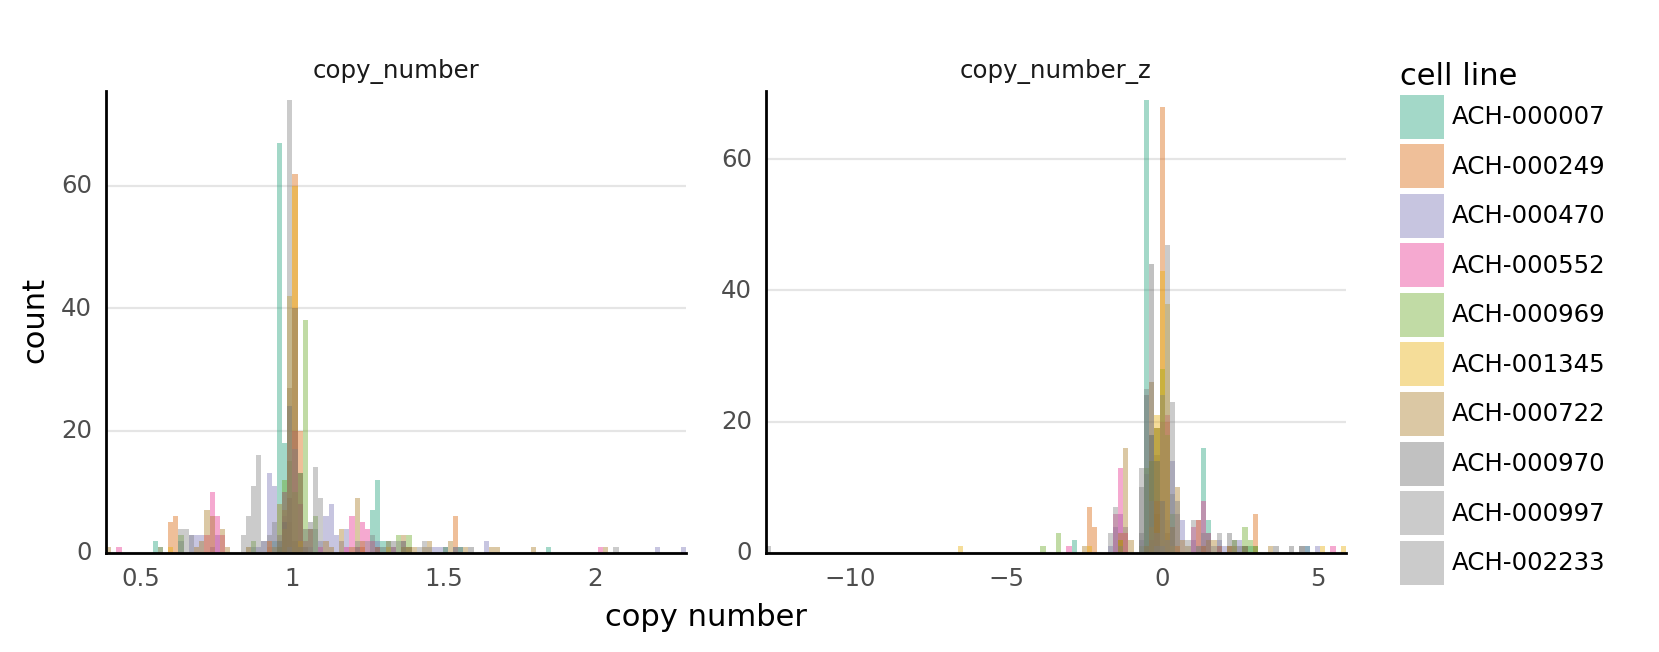

<ggplot: (8737801337567)>

In [9]:
plot_df = (
    data[["depmap_id", "hugo_symbol", "copy_number", "copy_number_z", "lfc"]]
    .drop_duplicates()
    .pivot_longer(
        index=["depmap_id", "hugo_symbol", "lfc"], names_to="cn", values_to="value"
    )
)
(
    gg.ggplot(plot_df.drop(columns=["lfc"]).drop_duplicates(), gg.aes(x="value"))
    + gg.facet_wrap("~cn", nrow=1, scales="free")
    + gg.geom_histogram(gg.aes(fill="depmap_id"), position="identity", alpha=0.4)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_fill_brewer(type="qual", palette="Dark2")
    + gg.theme(figure_size=(8, 3), panel_spacing_x=0.4)
    + gg.labs(x="copy number", y="count", fill="cell line")
)

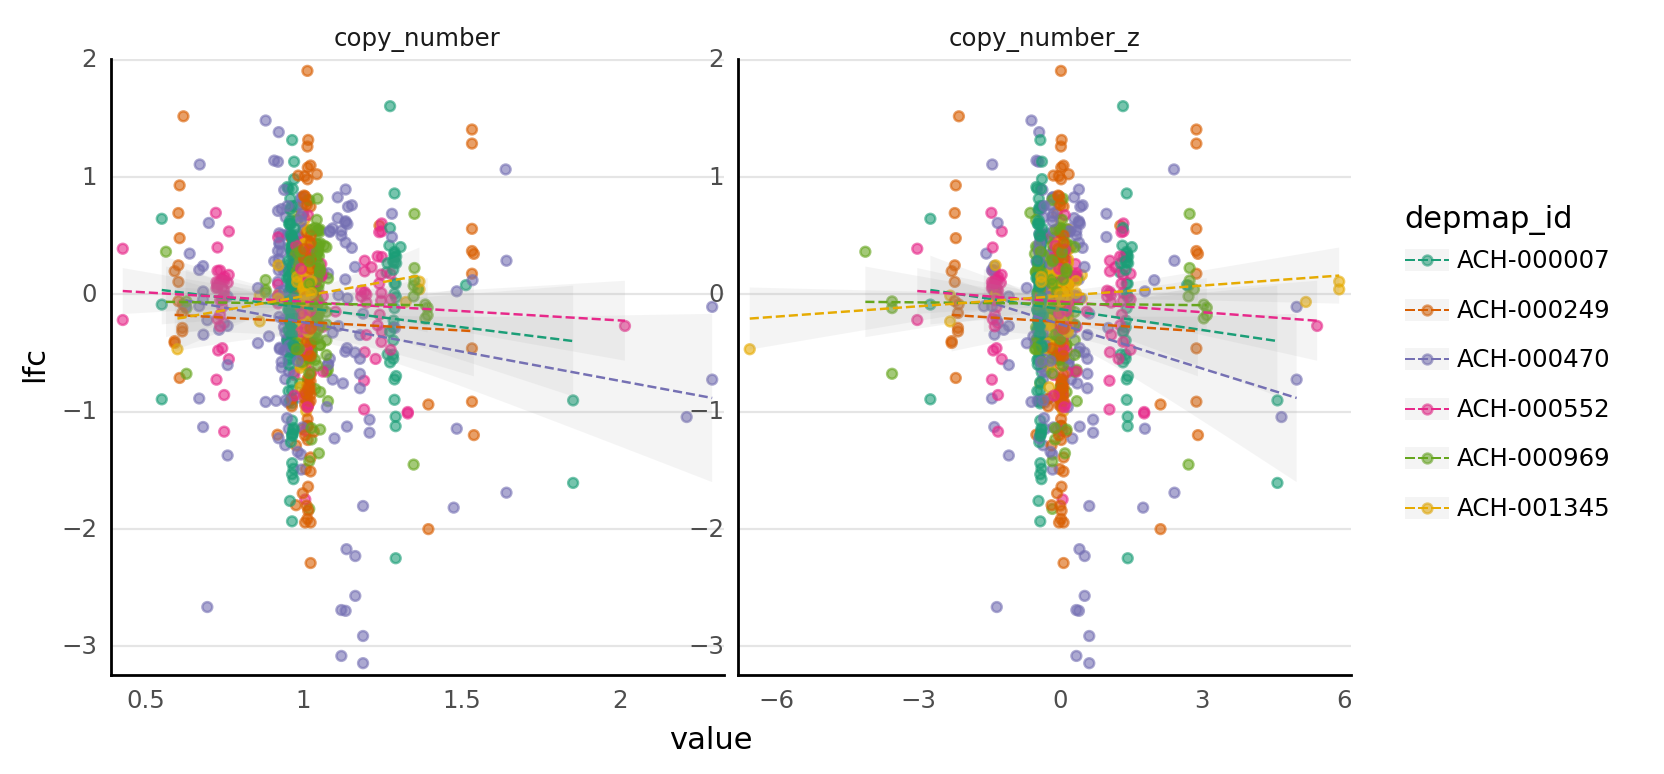

<ggplot: (351224098)>

In [9]:
(
    gg.ggplot(plot_df, gg.aes(x="value", y="lfc", color="depmap_id"))
    + gg.facet_wrap("~ cn", nrow=1, scales="free")
    + gg.geom_point(alpha=0.6)
    + gg.geom_smooth(formula="y~x", method="lm", linetype="--", size=0.5, alpha=0.1)
    + gg.scale_x_continuous(expand=(0.02, 0))
    + gg.scale_y_continuous(expand=(0.02, 0))
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.theme(figure_size=(8, 4))
)

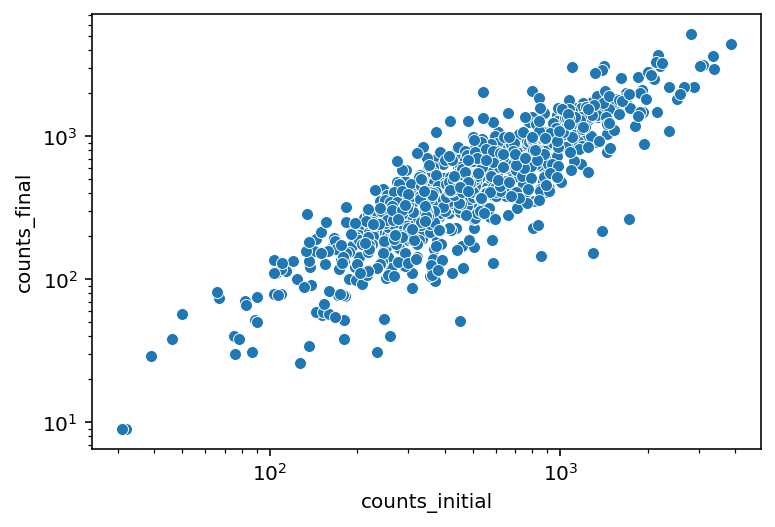

In [10]:
ax = sns.scatterplot(data=data, x="counts_initial", y="counts_final")
ax.set_yscale("log", base=10)
ax.set_xscale("log", base=10)
plt.show()

## Modeling

Fit models with hierarchical structure for gene and copy number effect per cell line.

For each model:

$$ 
\begin{aligned} 
\mu_{\beta_0} &\sim \text{N}(0, 2.5) \quad \sigma_{\beta_0} \sim \text{HN}(2.5) \\
\mu_{\beta_\text{CNA}} &\sim \text{N}(0, 2.5) \quad \sigma_{\beta_\text{CNA}} \sim \text{HN}(2.5) \\ 
\beta_0 &\sim_g \text{N}(\mu_{\beta_0}, \sigma_{\beta_0}) \\
\beta_\text{CNA} &\sim_c \text{N}(\mu_{\beta_\text{CNA}}, \sigma_{\beta_\text{CNA}}) \\
\end{aligned}
$$

For the negative binomial:

$$
\begin{aligned}
\eta &= \beta_0[g] + x_\text{CNA} \beta_\text{CNA}[c] \\
\mu &= \exp(\eta) \\
\alpha &\sim \text{HN}(0, 5) \\
y &\sim \text{NB}(\mu x_\text{initial}, \alpha)
\end{aligned}
$$

For the normal model:

$$
\begin{aligned}
\mu &= \beta_0[g] + x_\text{CNA} \beta_\text{CNA}[c] \\
\sigma &\sim \text{HN}(0, 5) \\
y &\sim \text{N}(\mu, \sigma)
\end{aligned}
$$

**The following two blocks show the data point(s) with 0 initial reads. This issue will be resolved in a new PR, then they can be deleted.**

In [41]:
data[data.counts_initial == 0][
    ["depmap_id", "hugo_symbol", "sgrna", "lfc", "counts_final", "counts_initial"]
]

In [ ]:
data = data[data.counts_initial > 0].reset_index(drop=True)

In [44]:
gene_idx, n_genes = dphelp.get_indices_and_count(data, "hugo_symbol")
print(f"number of genes: {n_genes}")

cell_line_idx, n_cells = dphelp.get_indices_and_count(data, "depmap_id")
print(f"number of cell lines: {n_cells}")

number of genes: 101
number of cell lines: 6


### Build models

#### Negative Binomial model

In [42]:
gene_copynumber_averages = vhelp.careful_zscore(
    data.groupby("hugo_symbol")["copy_number_z"].mean().values
)

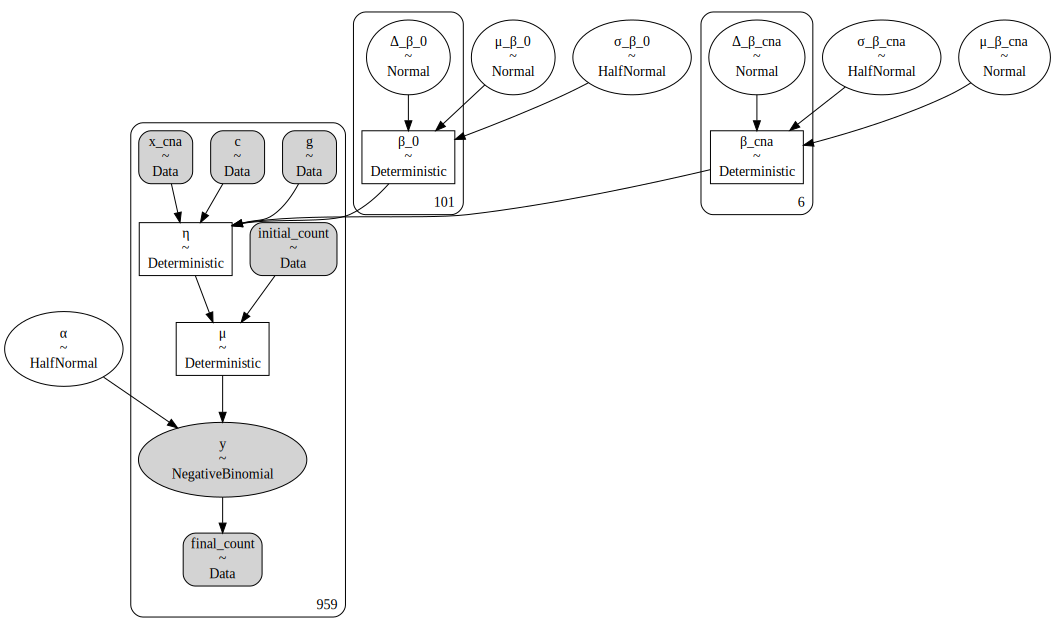

In [54]:
with pm.Model() as nb_model:
    g = pm.Data("g", gene_idx)
    c = pm.Data("c", cell_line_idx)
    x_cna = pm.Data("x_cna", data.copy_number_z.values)
    ct_i = pm.Data("initial_count", data.counts_initial.values)
    ct_f = pm.Data("final_count", data.counts_final.values)

    β_0 = pmhelp.hierarchical_normal(
        "β_0", shape=n_genes, centered=False, mu_sd=0.1, sigma_sd=0.1
    )
    β_cna = pmhelp.hierarchical_normal(
        "β_cna", shape=n_cells, centered=False, mu_sd=0.1, sigma_sd=0.1
    )
    η = pm.Deterministic("η", β_0[g] + β_cna[c] * x_cna)
    μ = pm.Deterministic("μ", pm.math.exp(η) * ct_i)
    α = pm.HalfNormal("α", 50)
    y = pm.NegativeBinomial("y", μ, α, observed=ct_f)

pm.model_to_graphviz(nb_model)

#### Normal linear regression model

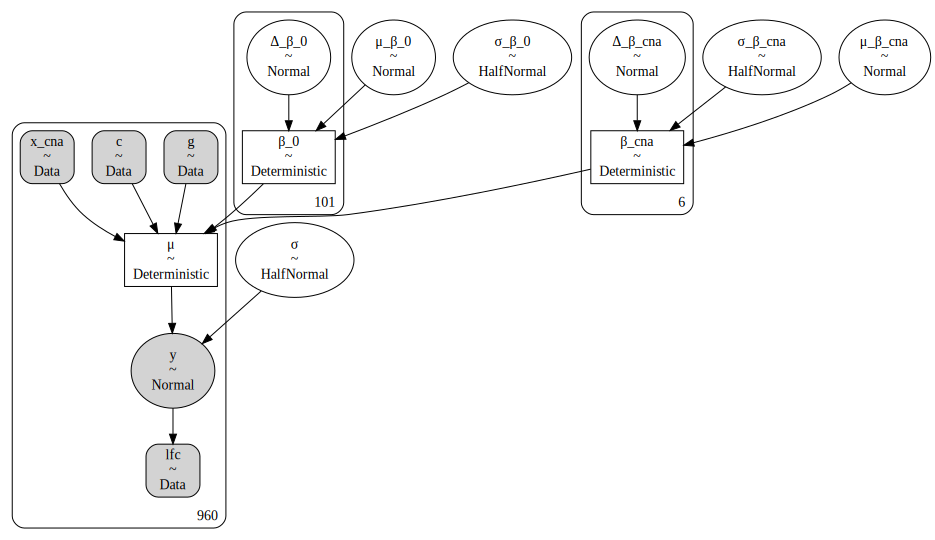

In [20]:
with pm.Model() as lin_model:
    g = pm.Data("g", gene_idx)
    c = pm.Data("c", cell_line_idx)
    x_cna = pm.Data("x_cna", data.copy_number_z.values)
    lfc = pm.Data("lfc", data.lfc.values)

    β_0 = pmhelp.hierarchical_normal(
        "β_0", shape=n_genes, centered=False, mu_sd=1.0, sigma_sd=1.0
    )
    β_cna = pmhelp.hierarchical_normal(
        "β_cna", shape=n_cells, centered=False, mu_sd=0.5, sigma_sd=1.0
    )
    μ = pm.Deterministic("μ", β_0[g] + β_cna[c] * x_cna)

    σ = pm.HalfNormal("σ", 1)

    y = pm.Normal("y", μ, σ, observed=lfc)

pm.model_to_graphviz(lin_model)

### Prior predictive checks

In [55]:
prior_pred_kwargs = {"samples": 500, "random_seed": RANDOM_SEED}

with nb_model:
    nb_prior_pred = pm.sample_prior_predictive(**prior_pred_kwargs)


with lin_model:
    lin_prior_pred = pm.sample_prior_predictive(**prior_pred_kwargs)

In [48]:
def summarize_array(a: np.ndarray, name: str) -> np.ndarray:
    return pd.DataFrame(
        {
            "min": a.min(),
            "25%": np.quantile(a, q=0.25).astype(int),
            "mean": a.mean().astype(int),
            "median": np.median(a),
            "75%": np.quantile(a, q=0.75).astype(int),
            "max": a.max(),
        },
        index=[name],
    )


def get_varnames_to_print(prior_pred: dict[str, np.ndarray]) -> list[str]:
    single_dim_vars: list[str] = []
    for varname, vals in prior_pred.items():
        if "log__" in varname or vals.ndim != 1:
            continue
        single_dim_vars.append(varname)
    return single_dim_vars


def plot_prior_pred_against_real(
    prior_pred_i: np.array,
    real_values: pd.Series,
    i: int,
    binwidth: float,
    x_lab: str = "value",
) -> gg.ggplot:
    plot = (
        gg.ggplot(
            pd.DataFrame({"model": prior_pred_i, "observed": real_values}).pivot_longer(
                names_to="source"
            ),
            gg.aes(x="value"),
        )
        + gg.geom_histogram(
            gg.aes(fill="source"), alpha=0.75, binwidth=binwidth, position="identity"
        )
        + gg.scale_x_continuous(expand=(0, 0))
        + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
        + gg.scale_fill_brewer(type="qual", palette="Set1")
        + gg.theme(
            figure_size=(8, 4),
            legend_title=gg.element_blank(),
            legend_position=(0.8, 0.3),
            legend_background=gg.element_blank(),
        )
        + gg.labs(
            x=x_lab,
            y="count",
            title=f"Prior predictive distribution (#{i})",
        )
    )
    return plot

In [49]:
def prior_pred_analysis(
    prior_pred: dict[str, np.ndarray],
    real_values: pd.Series,
    x_lab: str,
    num_examples: int = 5,
    hist_binwidth: float = 1.0,
) -> None:
    print("Comparison of range of predicted values")
    print(
        pd.concat(
            [
                summarize_array(prior_pred["y"], "model"),
                summarize_array(real_values.values, "real"),
            ]
        )
    )
    print()

    fold_diff = prior_pred["y"].max() / real_values.max()
    print(f"Fold difference in maximum values: {fold_diff:0.2f}")

    for i in np.random.choice(
        np.arange(prior_pred["y"].shape[0]), size=num_examples, replace=False
    ):
        print(
            plot_prior_pred_against_real(
                prior_pred["y"][i, :],
                real_values,
                i=i,
                binwidth=hist_binwidth,
                x_lab=x_lab,
            )
        )
        params: dict[str, float] = {}
        for v in get_varnames_to_print(prior_pred):
            params[v] = np.round(prior_pred[v][i], 2)
        pprint.pprint(params)

Comparison of range of predicted values
       min  25%  mean  median  75%    max
model    0  283   615   447.0  762  33945
real     9  277   611   423.0  755   5230

Fold difference in maximum values: 6.49


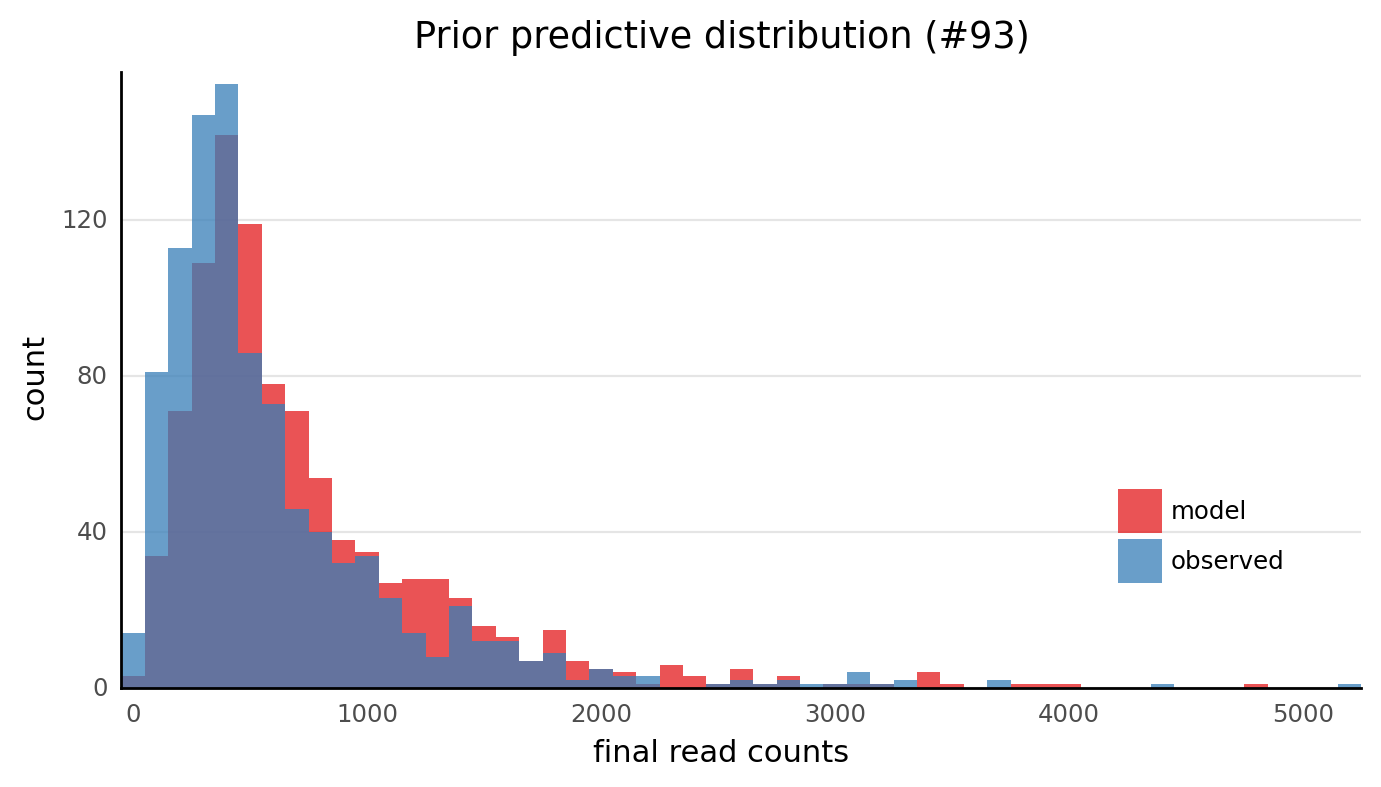


{'α': 32.67, 'μ_β_0': 0.2, 'μ_β_cna': -0.06, 'σ_β_0': 0.01, 'σ_β_cna': 0.13}


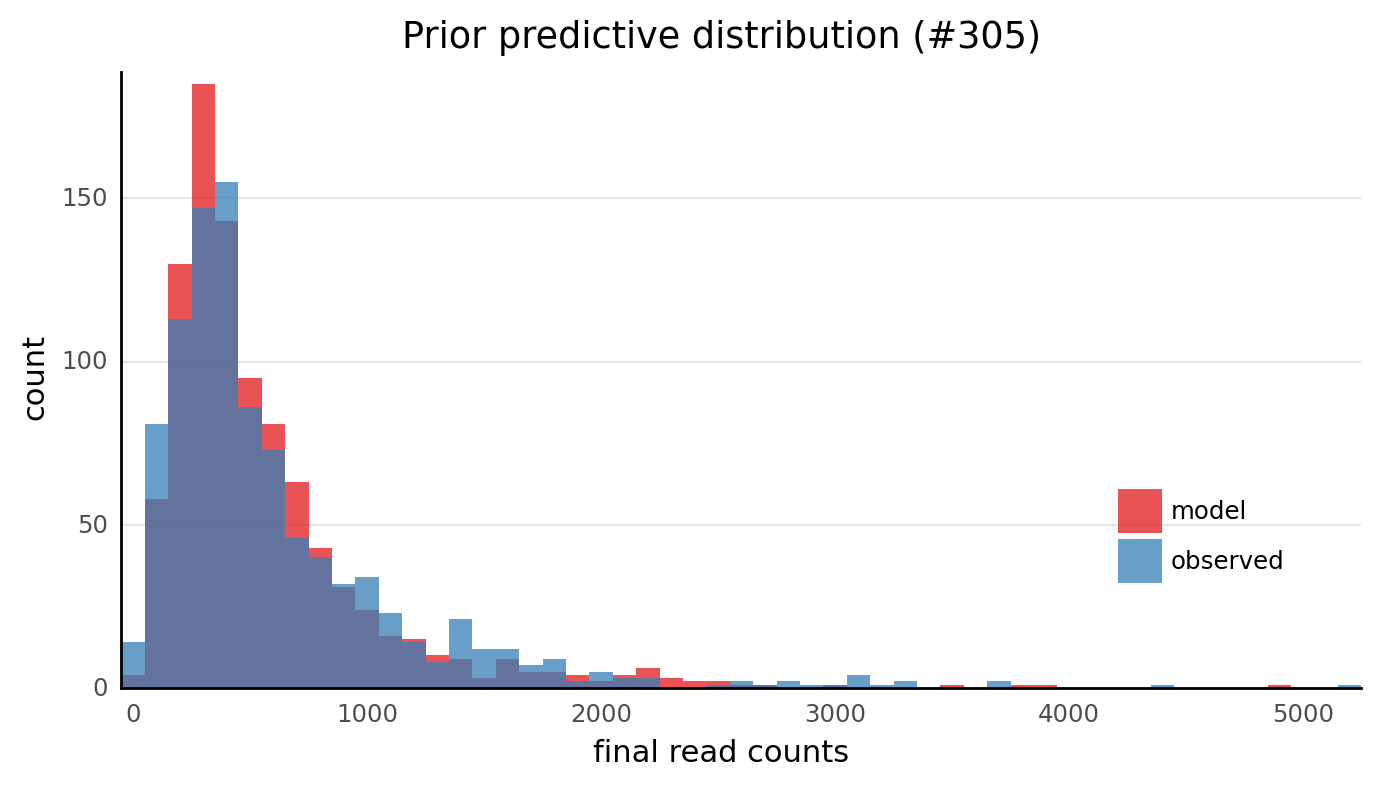


{'α': 58.12, 'μ_β_0': -0.09, 'μ_β_cna': 0.26, 'σ_β_0': 0.07, 'σ_β_cna': 0.01}


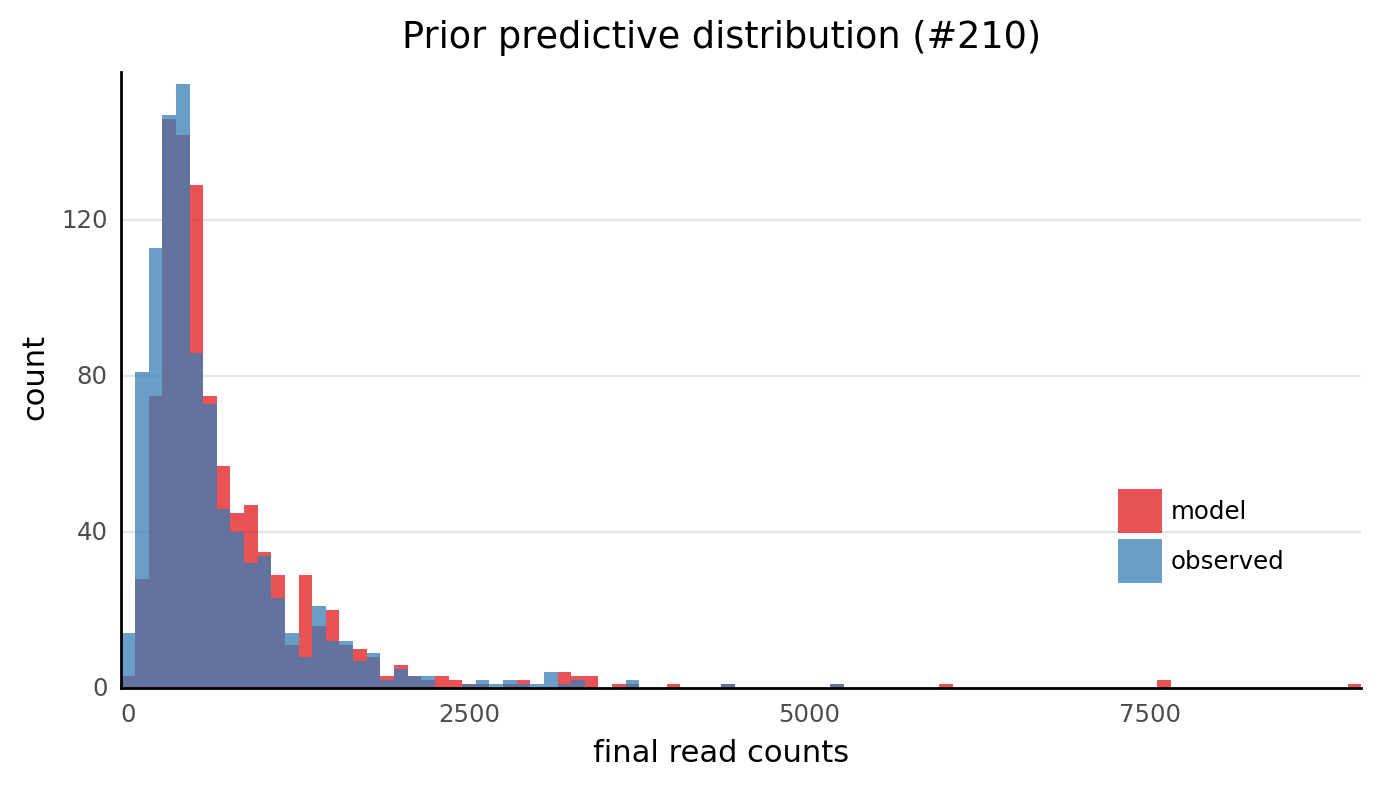


{'α': 86.1, 'μ_β_0': 0.15, 'μ_β_cna': 0.08, 'σ_β_0': 0.1, 'σ_β_cna': 0.18}


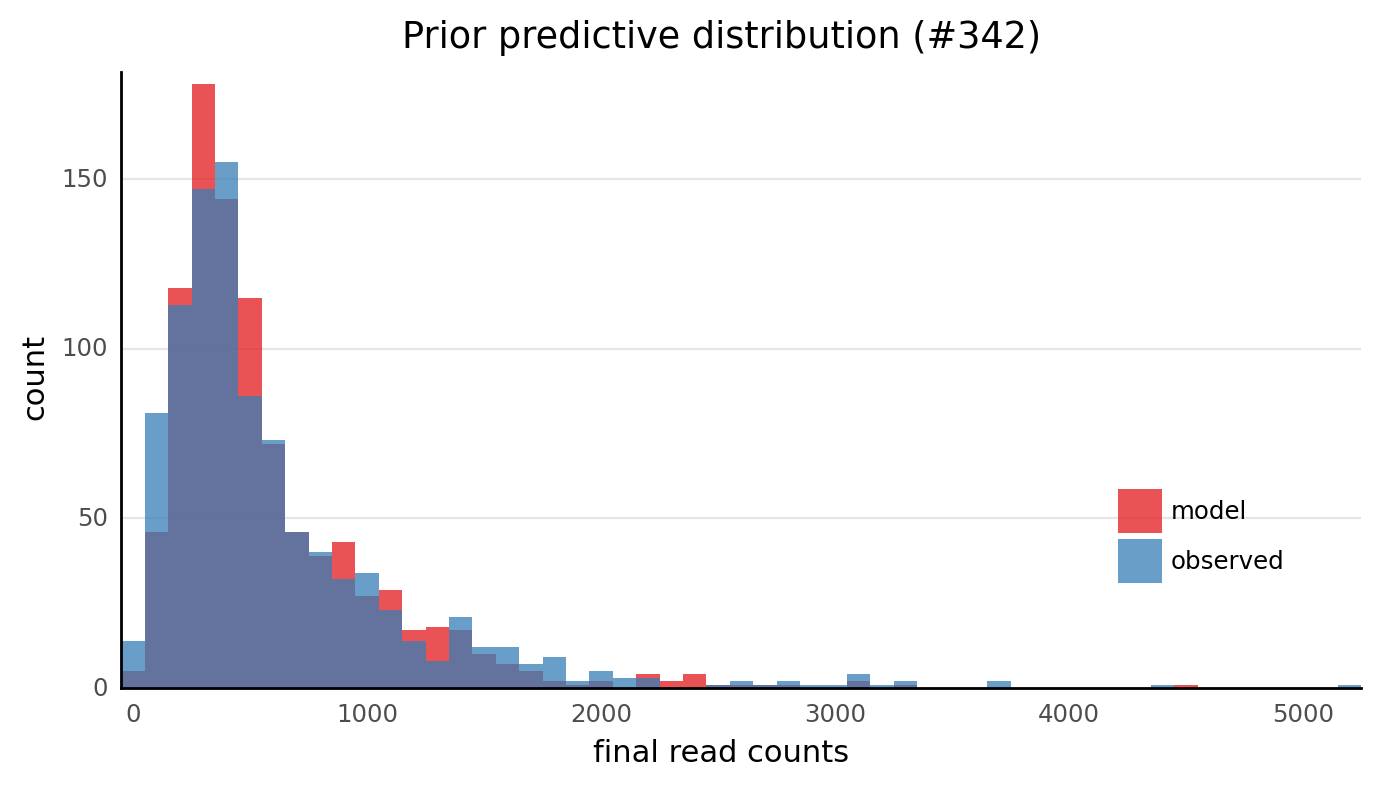


{'α': 58.57, 'μ_β_0': -0.02, 'μ_β_cna': 0.03, 'σ_β_0': 0.01, 'σ_β_cna': 0.02}


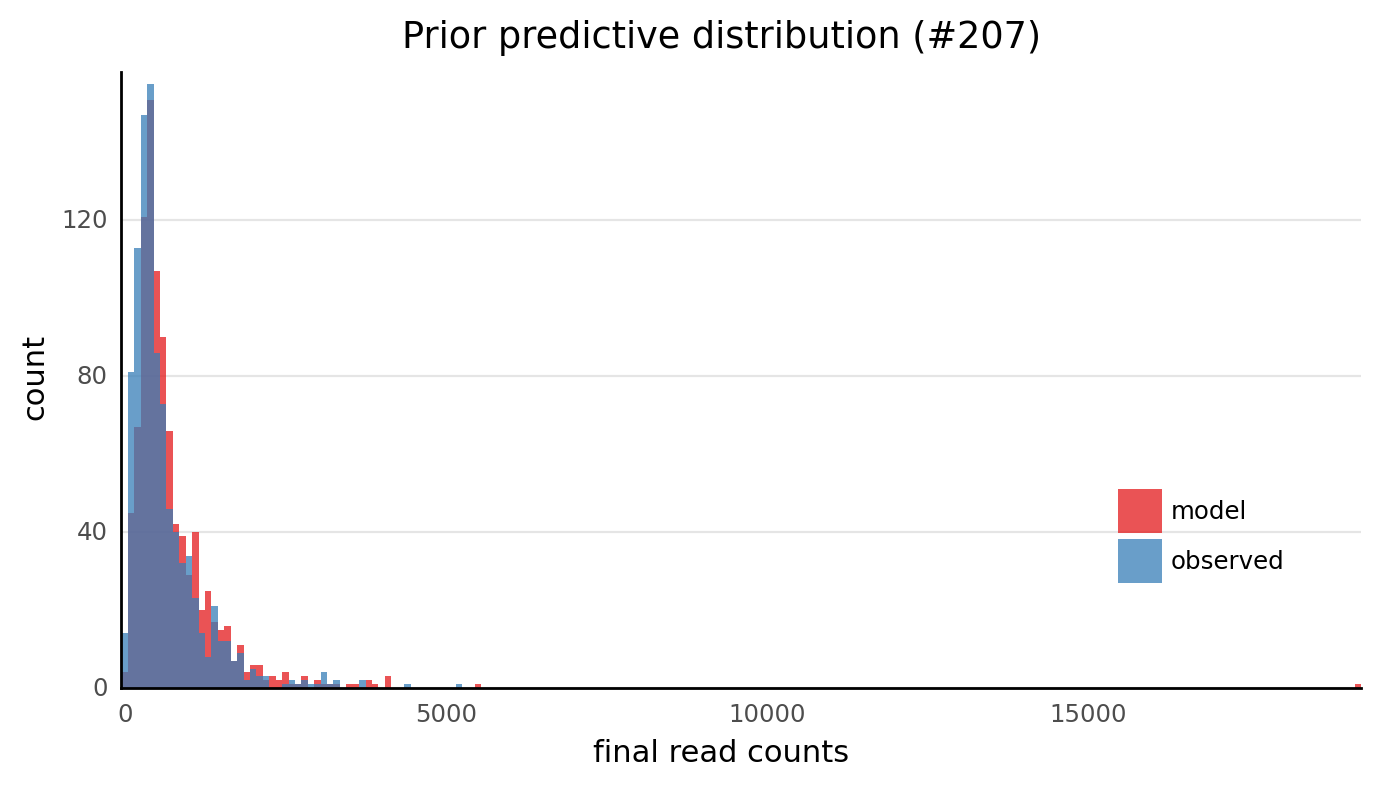


{'α': 117.32, 'μ_β_0': 0.16, 'μ_β_cna': 0.05, 'σ_β_0': 0.05, 'σ_β_cna': 0.24}


In [56]:
prior_pred_analysis(
    nb_prior_pred,
    real_values=data.counts_final,
    x_lab="final read counts",
    hist_binwidth=100,
)

Comparison of range of predicted values
             min  25%  mean    median  75%        max
model -30.175508   -1     0  0.037721    1  36.470539
real   -3.145193    0     0 -0.025503    0   1.905343

Fold difference in maximum values: 19.14


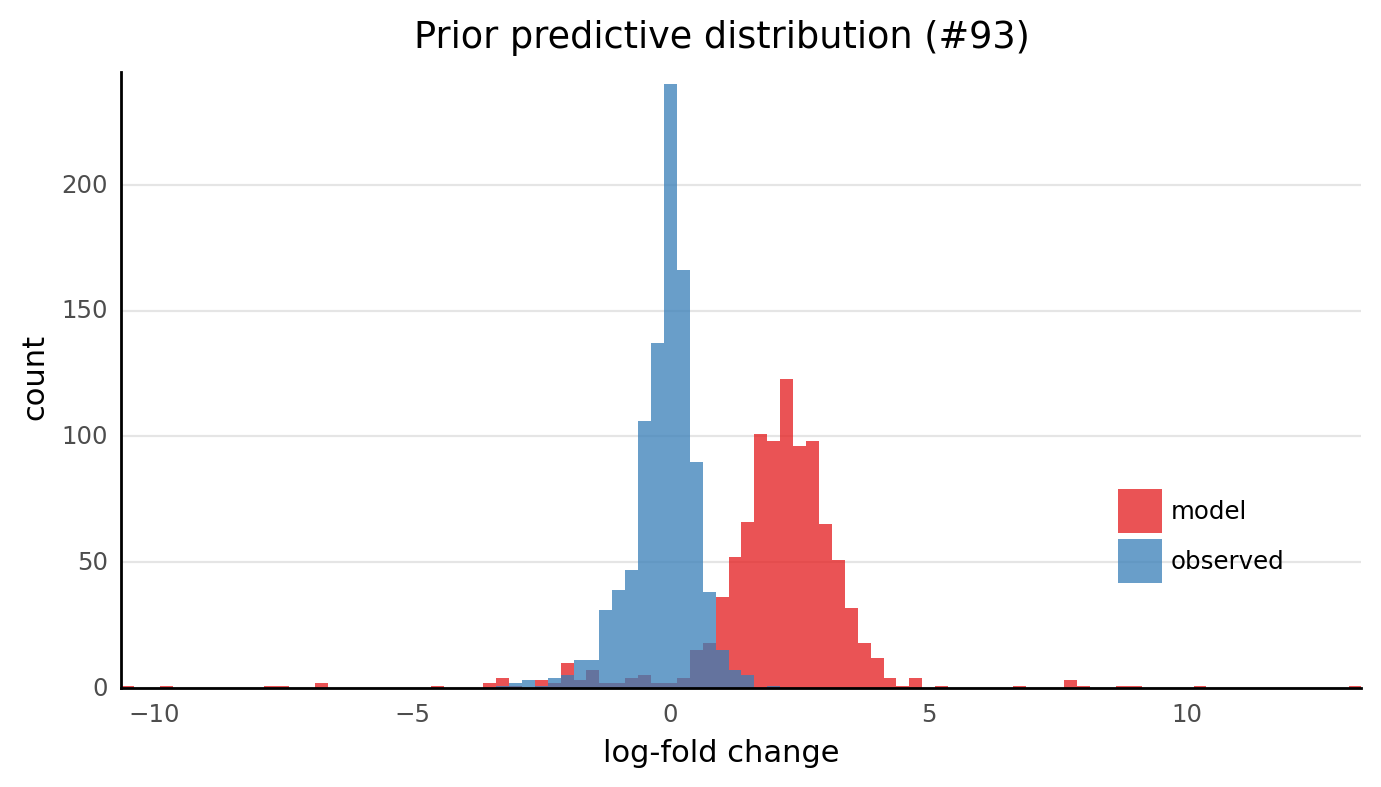


{'μ_β_0': 2.04, 'μ_β_cna': -0.29, 'σ': 0.65, 'σ_β_0': 0.09, 'σ_β_cna': 1.27}


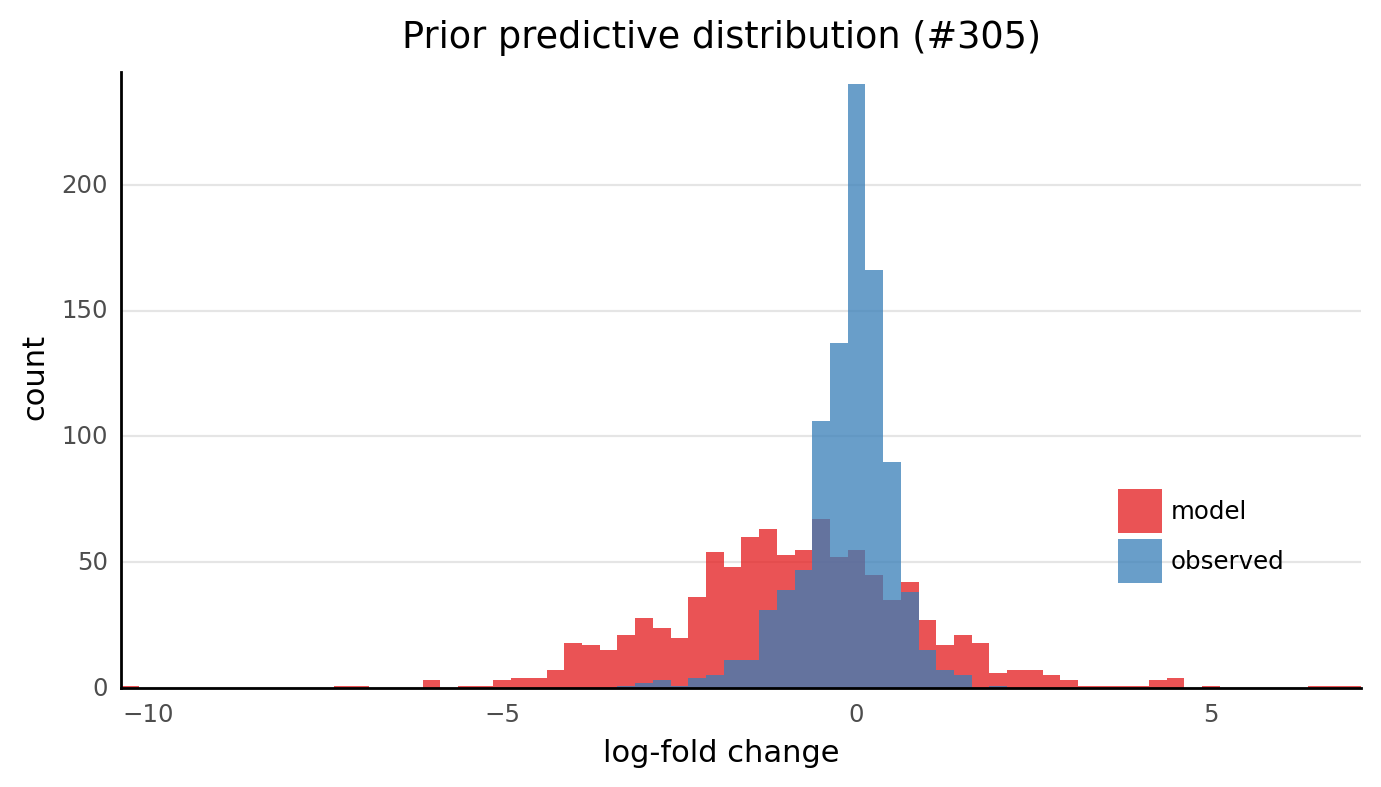


{'μ_β_0': -0.85, 'μ_β_cna': 1.29, 'σ': 1.16, 'σ_β_0': 0.67, 'σ_β_cna': 0.1}


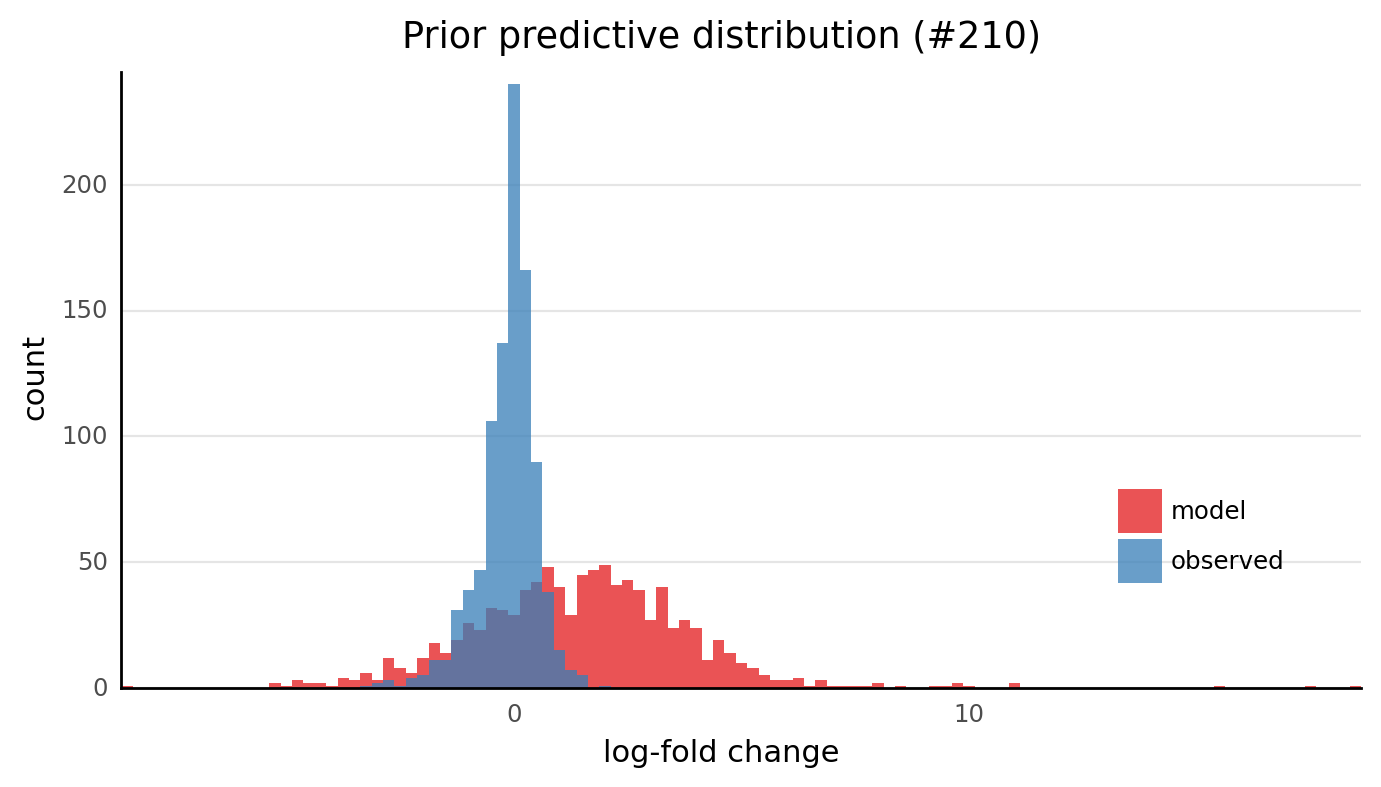


{'μ_β_0': 1.47, 'μ_β_cna': 0.41, 'σ': 1.72, 'σ_β_0': 0.99, 'σ_β_cna': 1.85}


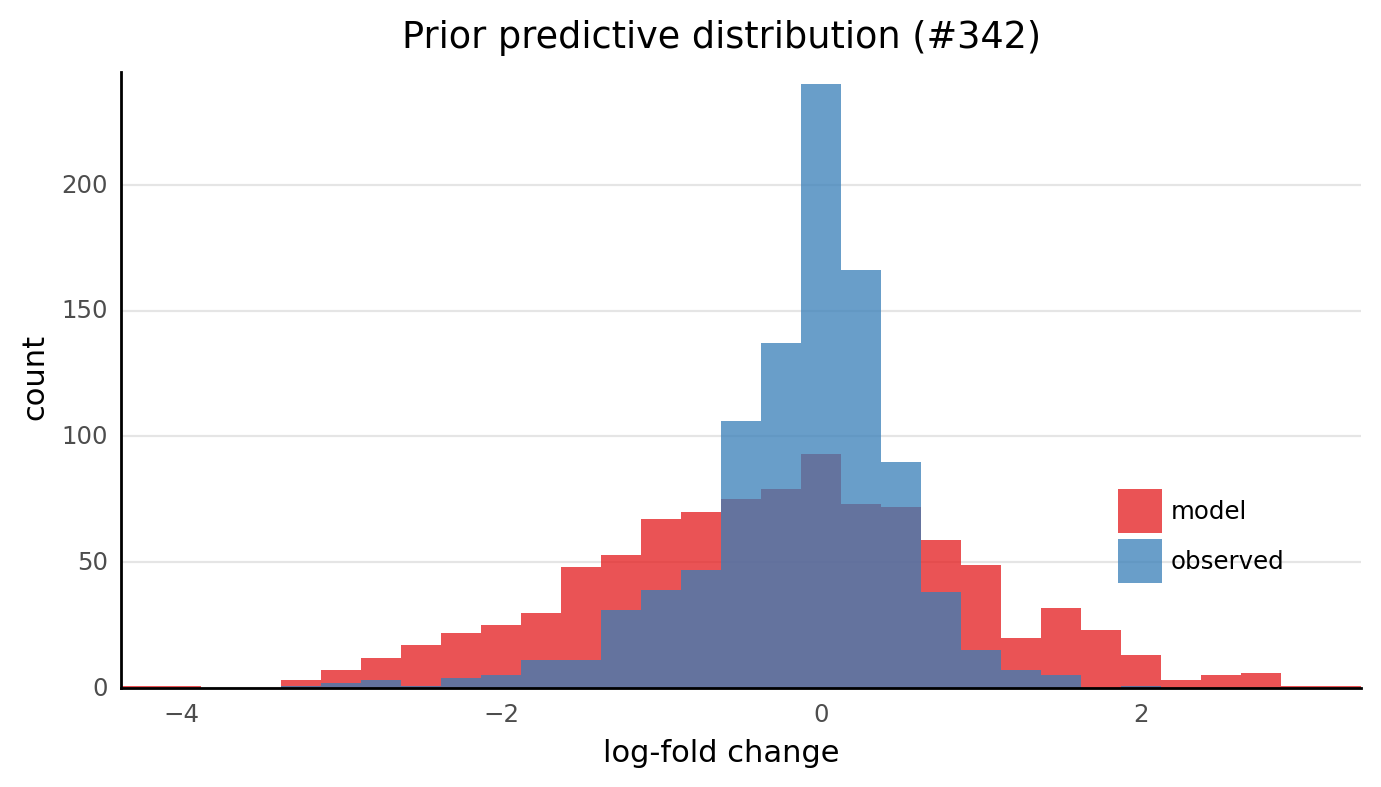


{'μ_β_0': -0.23, 'μ_β_cna': 0.15, 'σ': 1.17, 'σ_β_0': 0.09, 'σ_β_cna': 0.21}


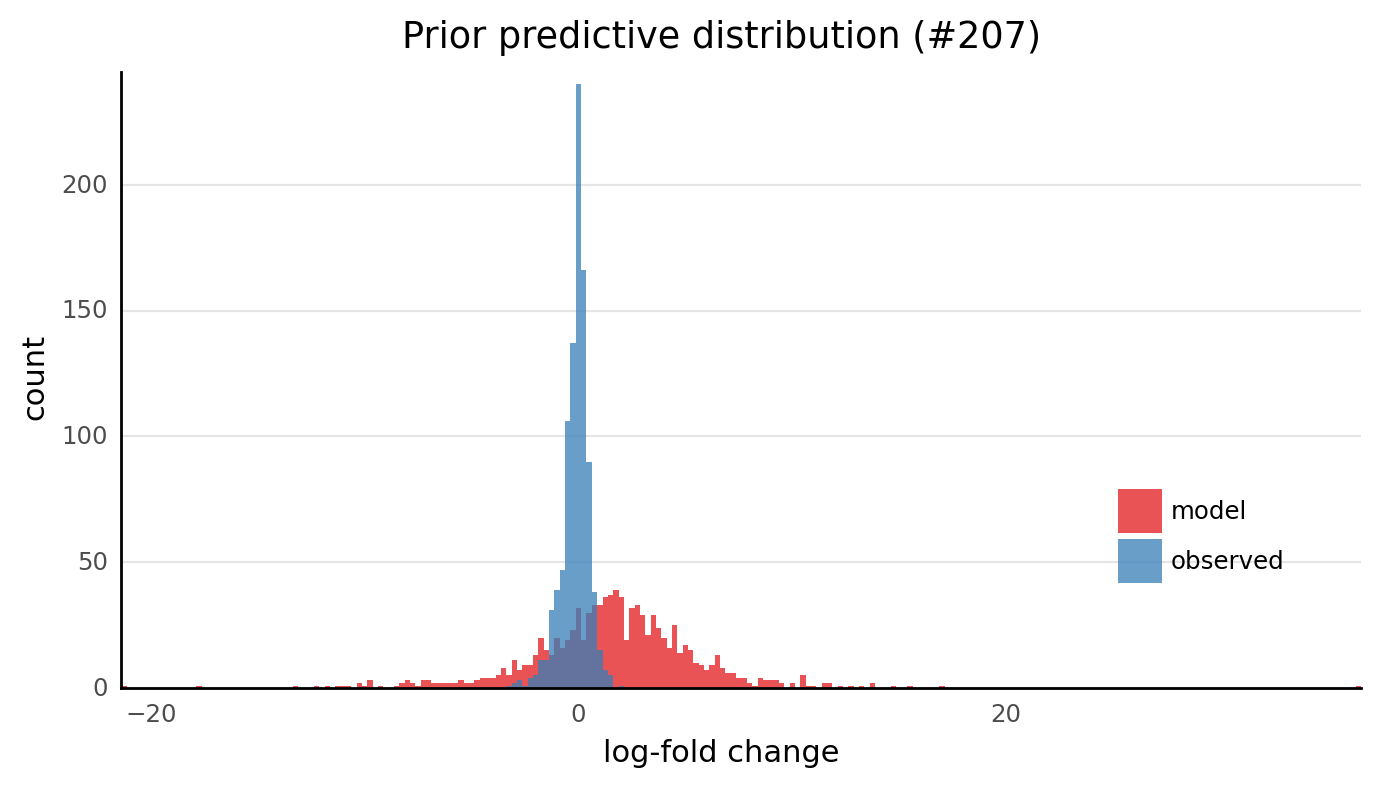


{'μ_β_0': 1.58, 'μ_β_cna': 0.27, 'σ': 2.35, 'σ_β_0': 0.48, 'σ_β_cna': 2.36}


In [22]:
prior_pred_analysis(
    lin_prior_pred,
    real_values=data.lfc,
    x_lab="log-fold change",
    hist_binwidth=0.25,
)

### Sampling from the models

In [57]:
pm_sample_kwargs = {
    "draws": 1000,
    "chains": 4,
    "tune": 2000,
    "random_seed": [349 + 1 for i in range(4)],
    "target_accept": 0.95,
    "return_inferencedata": True,
}
pm_sample_ppc_kwargs = {"random_seed": 400}

I timed the sampling processes a few times and put together the following table to show how long each model takes to run inference:

| model  | sampling (sec.) | post. pred. (sec.) | total (min.) |
|--------|-----------------|--------------------|--------------|
| NB     | 59              | 64                 | 2.23         |
| normal | 38              | 73                 | 1.98         |

In [52]:
tic = time()

with nb_model:
    nb_trace = pm.sample(**pm_sample_kwargs, start={"α_log__": np.array(5)})
    ppc = pm.sample_posterior_predictive(nb_trace, **pm_sample_ppc_kwargs)
    ppc["lfc"] = np.log2(ppc["y"] / data["counts_initial"].values)
    nb_trace.extend(az.from_pymc3(posterior_predictive=ppc))

toc = time()
print(f"sampling required {(toc - tic) / 60:.2f} minutes")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [α, Δ_β_0, σ_β_0, μ_β_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 83 seconds.


sampling required 2.38 minutes


In [21]:
tic = time()

with lin_model:
    lin_trace = pm.sample(**pm_sample_kwargs)
    ppc = pm.sample_posterior_predictive(lin_trace, **pm_sample_ppc_kwargs)
    lin_trace.extend(az.from_pymc3(posterior_predictive=ppc))

toc = time()
print(f"sampling required {(toc - tic) / 60:.2f} minutes")

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 21500
Interrupted at 21,499 [10%]: Average Loss = 1,247
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, Δ_β_cna, σ_β_cna, μ_β_cna, Δ_β_0, σ_β_0, μ_β_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


sampling required 1.93 minutes


## Model comparison

### LOO-CV

We can compare the models using LOO-CV to see which is more robust to changes to individual data points.
It looks like the normal model is far superior to the NB model.
I am concerned that these are not comparable, though.

In [33]:
model_collection: dict[str, az.InferenceData] = {
    "negative binomial": nb_trace,
    "normal": lin_trace,
}
model_comparison = az.compare(model_collection)
model_comparison

rank          loo      p_loo        d_loo  weight  \
normal                0  -498.413064  42.690541     0.000000     1.0   
negative binomial     1 -3675.823353  39.864054  3177.410289     0.0   

                          se        dse  warning loo_scale  
normal             22.796215   0.000000    False       log  
negative binomial  25.443751  20.839538    False       log

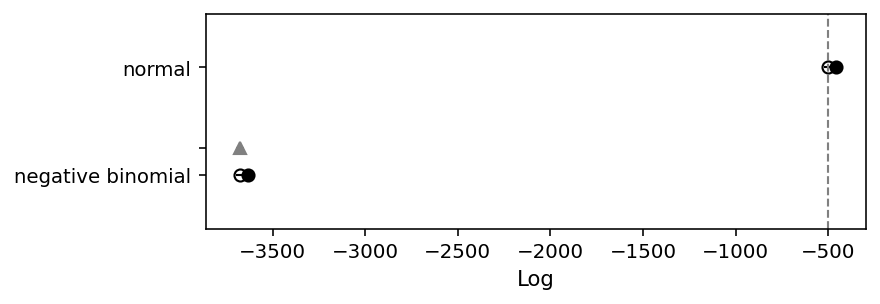

In [34]:
az.plot_compare(model_comparison);

Also, the LOO probability integral transformation (PIT) predictive checks ([ArviZ doc](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_loo_pit.html) indicate that the normal model is a better fit.
My concern is that this test is only for continuous data.

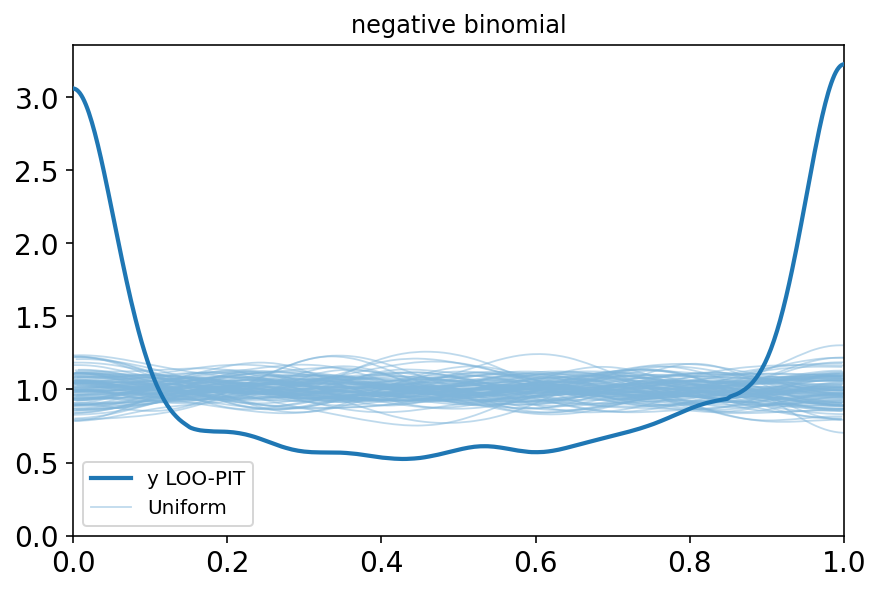

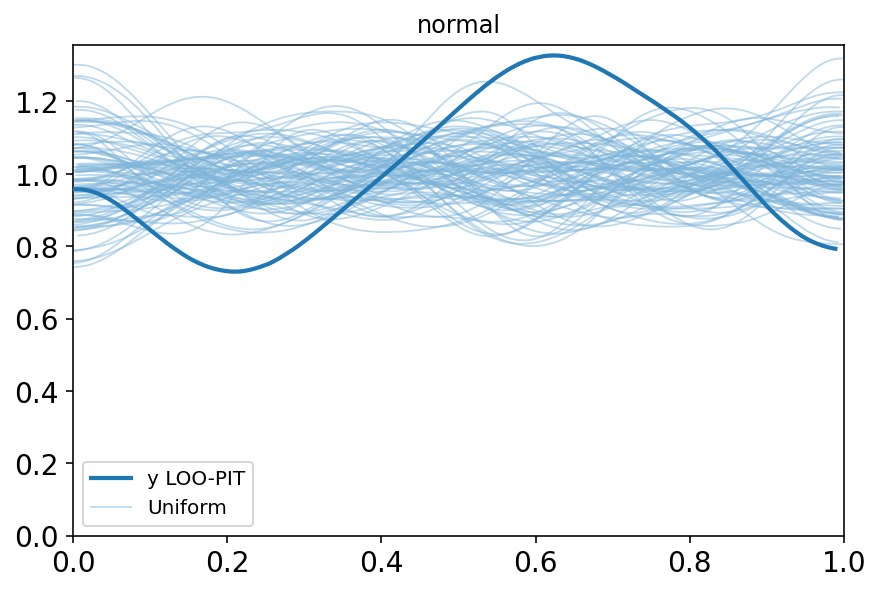

In [35]:
for name, idata in model_collection.items():
    az.plot_loo_pit(idata, y="y")
    plt.title(name)
    plt.show()

### Posterior distributions

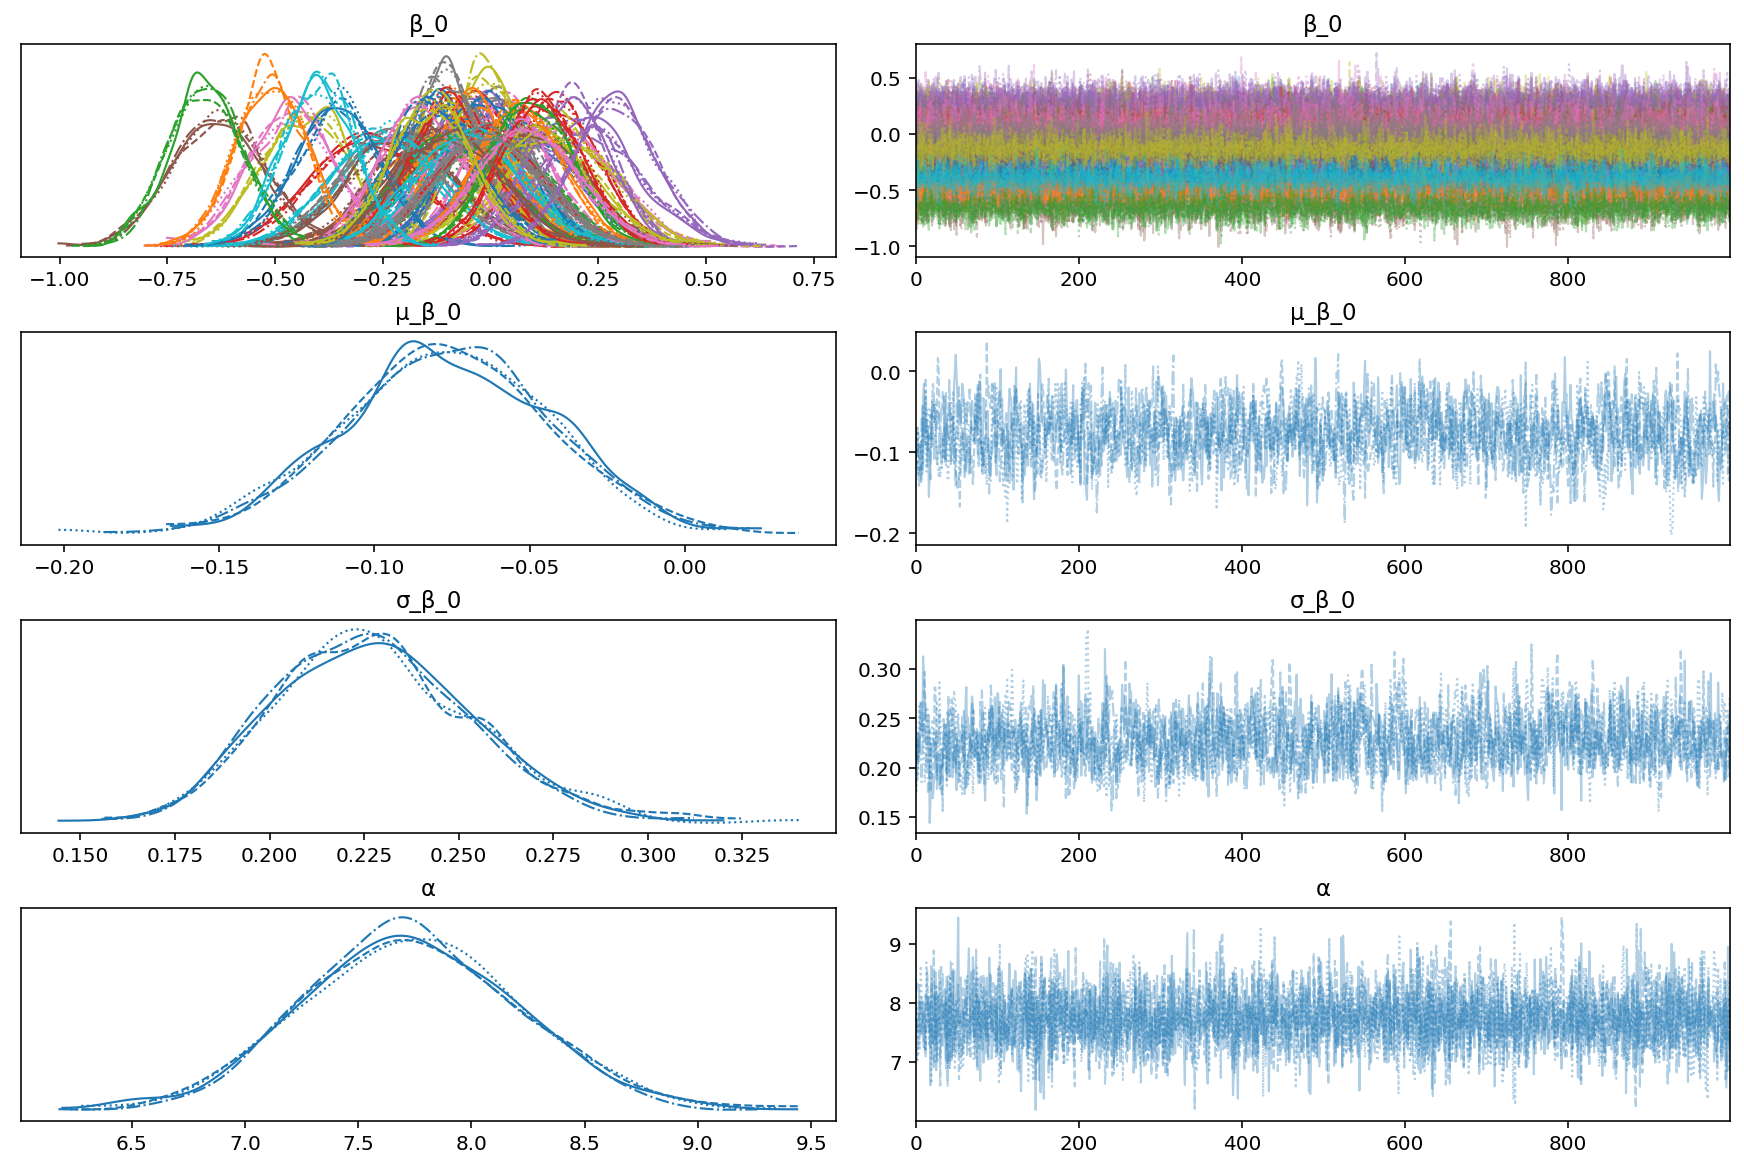

In [36]:
shared_varnames = ["β_0", "μ_β_0", "σ_β_0"]
nb_varnames = shared_varnames.copy() + ["α"]
az.plot_trace(nb_trace, var_names=nb_varnames);

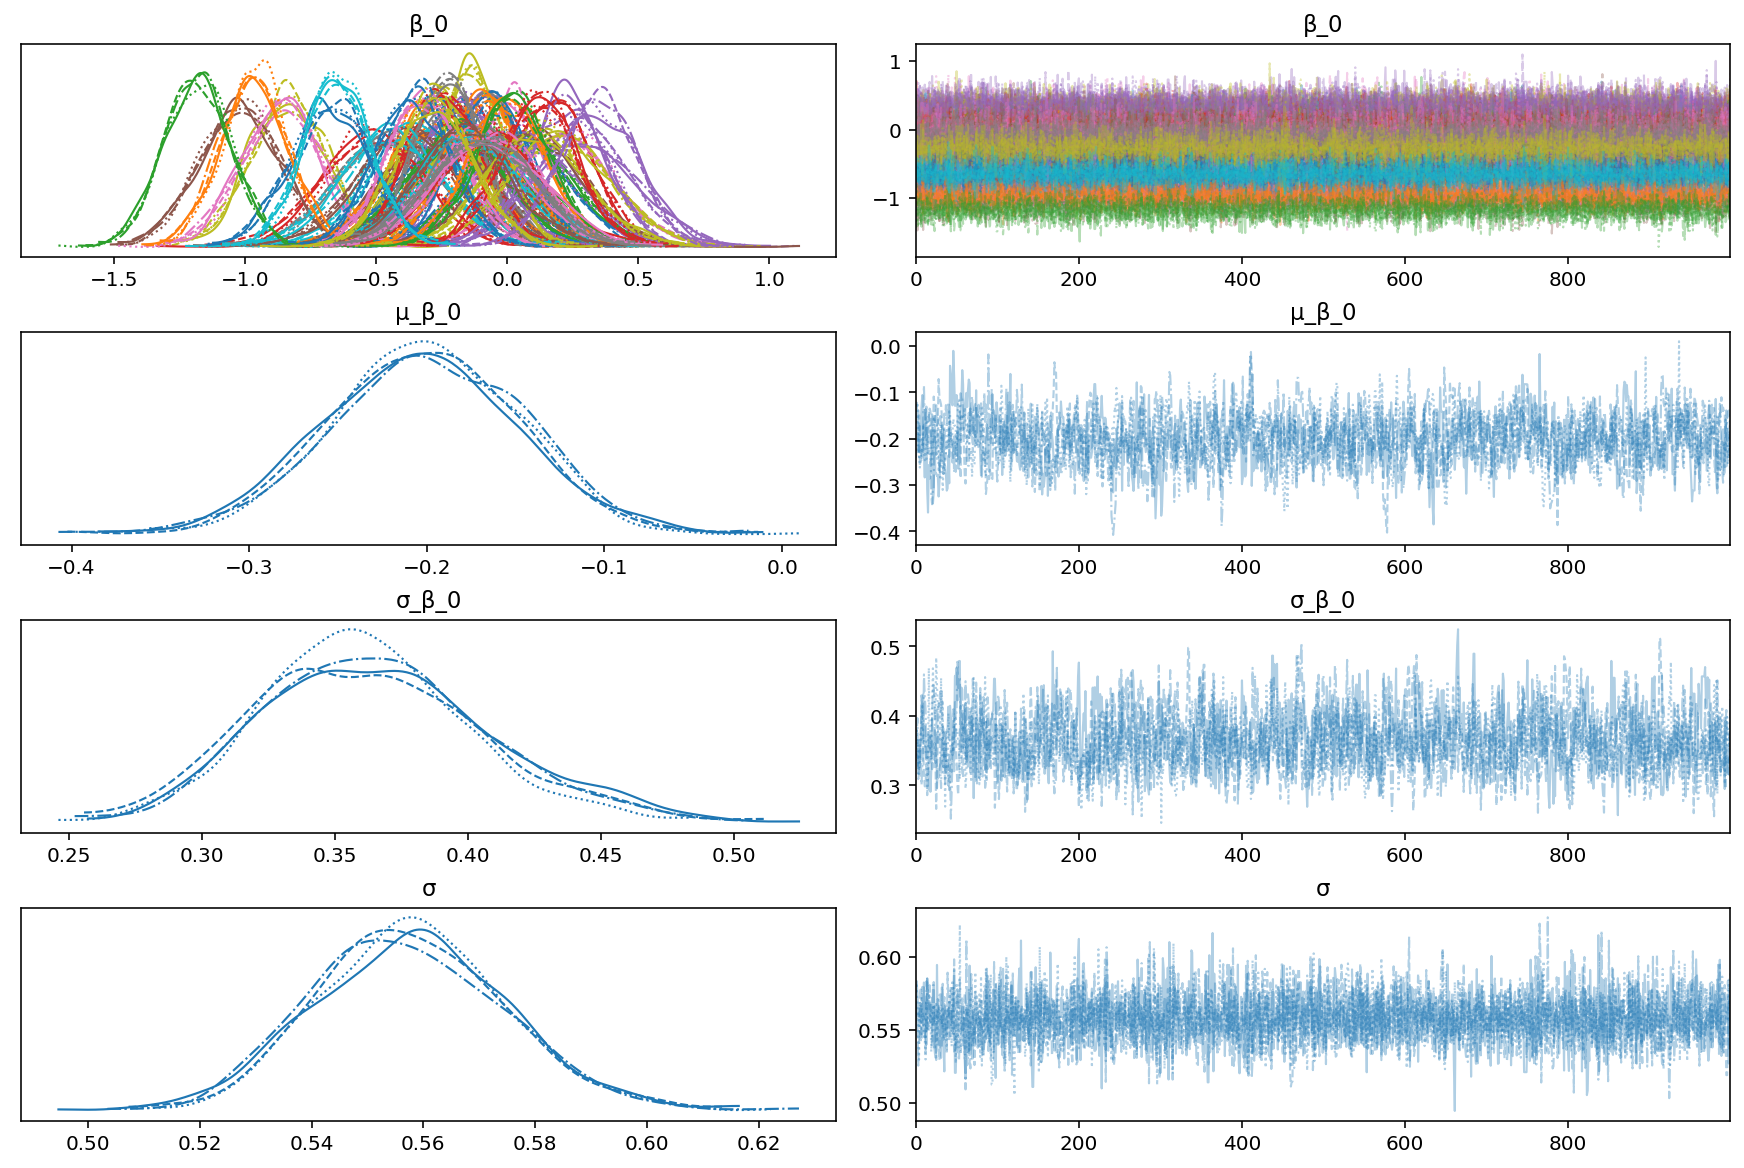

In [37]:
lin_varnames = shared_varnames.copy() + ["σ"]
az.plot_trace(lin_trace, var_names=lin_varnames);

In [38]:
def get_beta_0_summary(name: str, idata: az.InferenceData) -> pd.DataFrame:
    return (
        az.summary(idata, var_names="β_0", kind="stats", hdi_prob=0.89)
        .assign(hugo_symbol=data.hugo_symbol.cat.categories, model=name)
        .reset_index(drop=False)
        .rename(columns={"index": "parameter"})
    )


beta_0_post = pd.concat([get_beta_0_summary(n, d) for n, d in model_collection.items()])
beta_0_post.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5% hugo_symbol              model
0    β_0[0]  0.081  0.121    -0.115      0.268      ACVR1C  negative binomial
1    β_0[1] -0.088  0.095    -0.243      0.056     ADPRHL1  negative binomial
2    β_0[2]  0.093  0.120    -0.095      0.279         APC  negative binomial
3    β_0[3] -0.034  0.094    -0.191      0.107        BRAF  negative binomial
4    β_0[4] -0.004  0.097    -0.165      0.144        CCR3  negative binomial

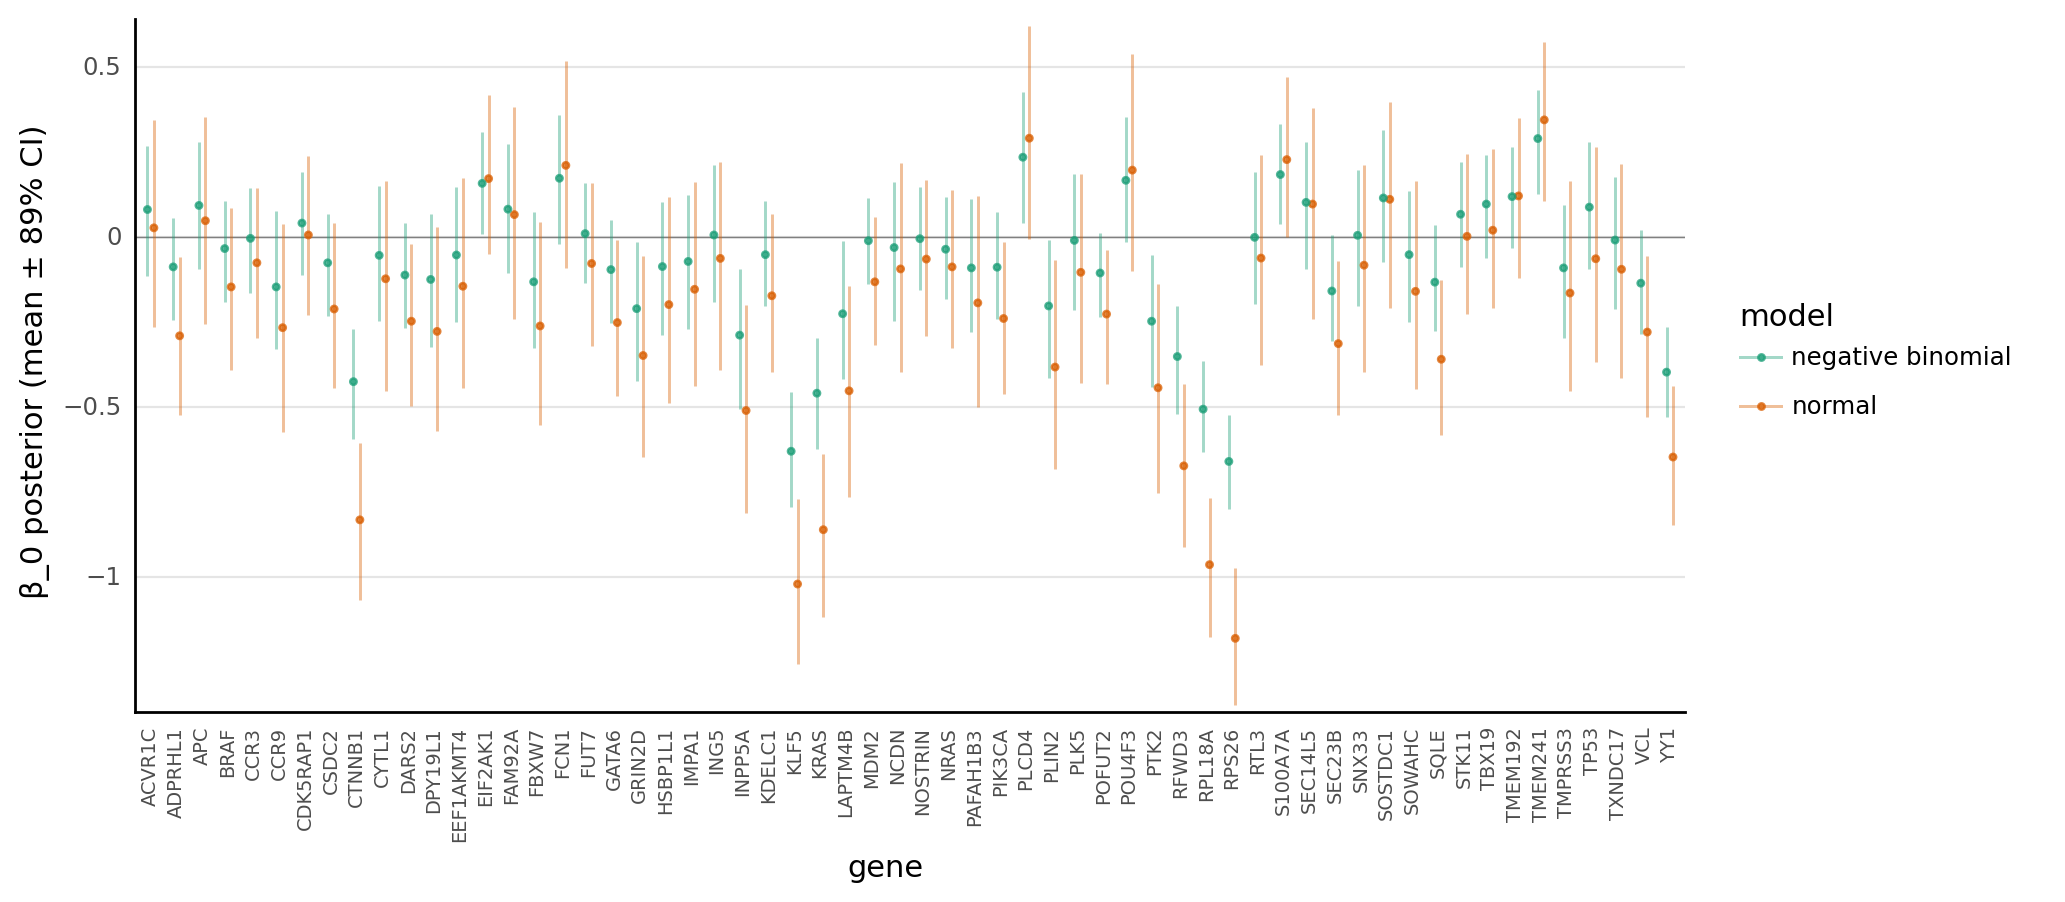

<ggplot: (351384028)>

In [39]:
pos = gg.position_dodge(width=0.5)

(
    gg.ggplot(beta_0_post, gg.aes(x="hugo_symbol", y="mean", color="model"))
    + gg.geom_hline(yintercept=0, linetype="-", size=0.3, color="grey")
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), position=pos, size=0.6, alpha=0.4
    )
    + gg.geom_point(position=pos, size=0.8, alpha=0.75)
    + gg.scale_y_continuous(expand=(0.01, 0))
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=7), figure_size=(10, 4.5))
    + gg.labs(x="gene", y="β_0 posterior (mean ± 89% CI)")
)

posterior distributions in negative binomial model


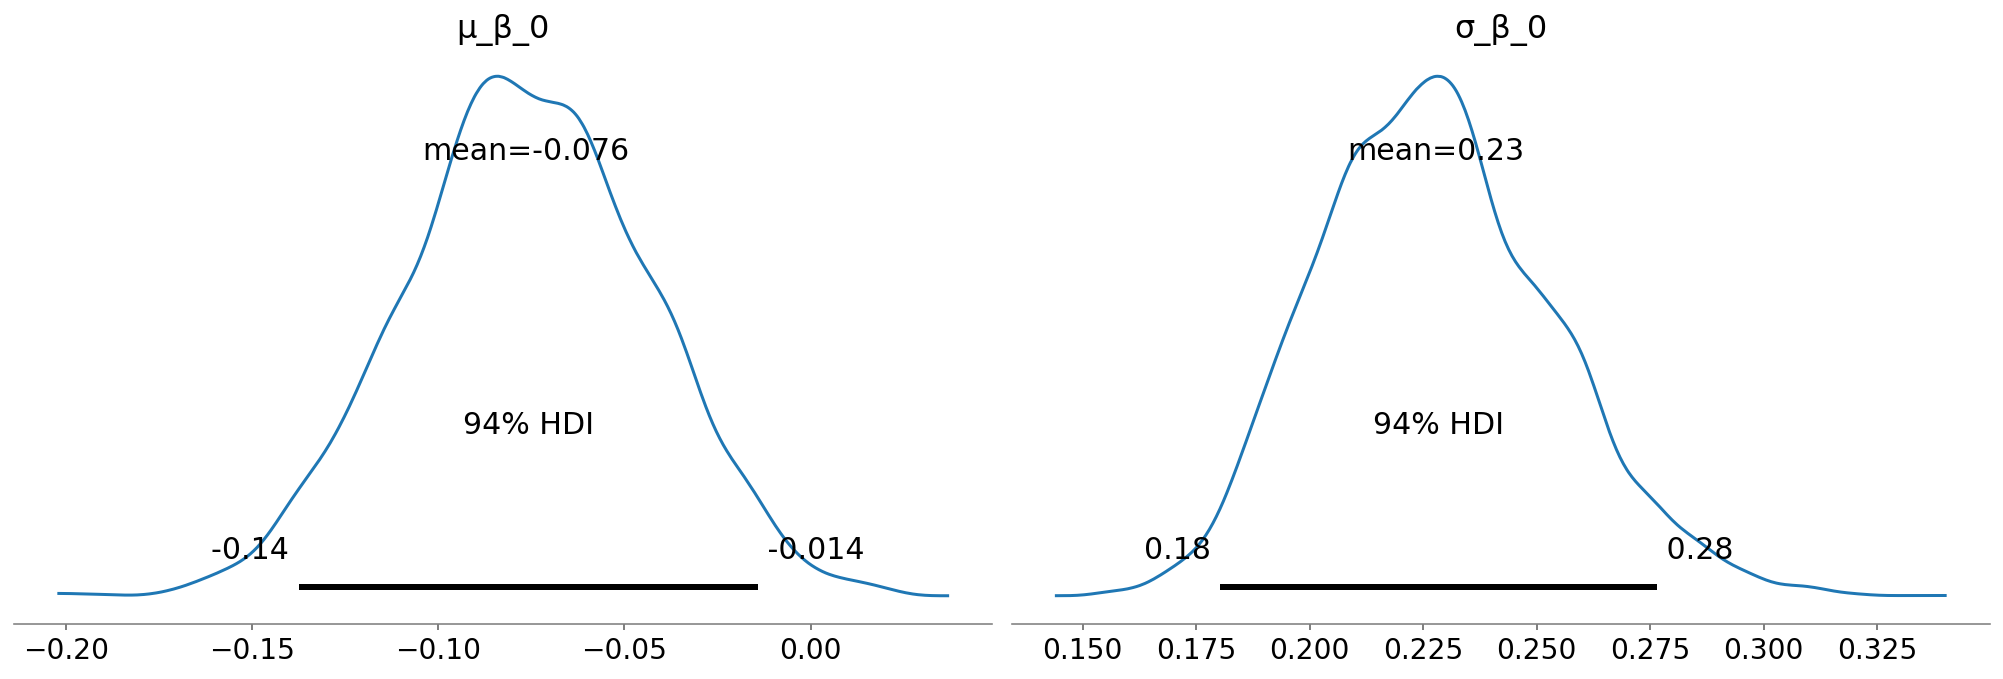

--------------------------------------------------------------------------------
posterior distributions in normal model


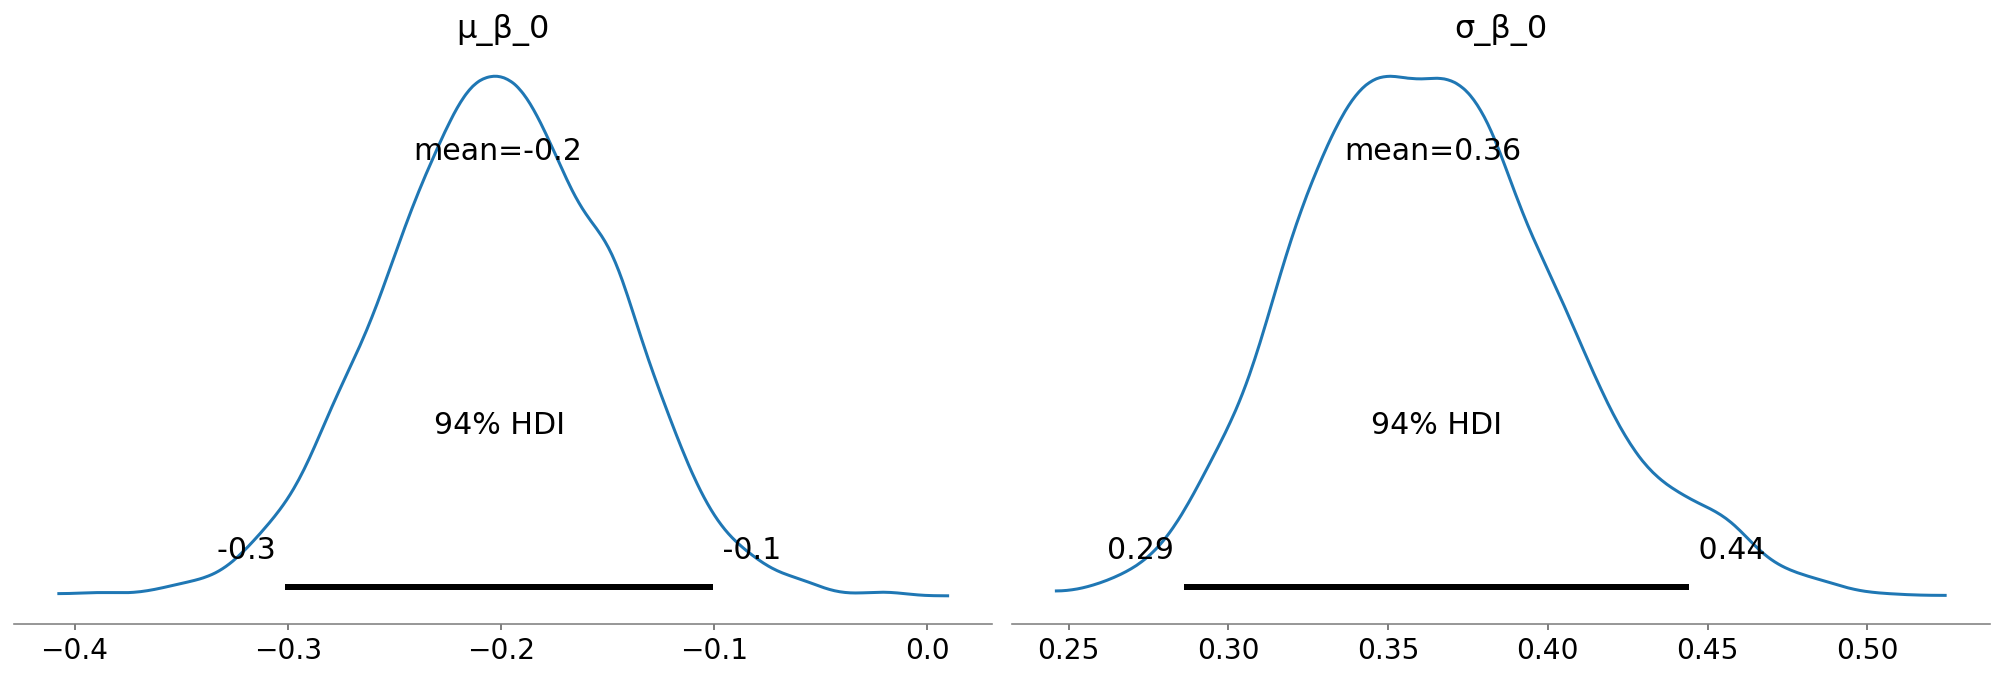

--------------------------------------------------------------------------------


In [40]:
for name, idata in model_collection.items():
    print(f"posterior distributions in {name} model")
    az.plot_posterior(idata, var_names=["μ_β_0", "σ_β_0"])
    plt.show()
    print("-" * 80)

### Posterior predictive checks

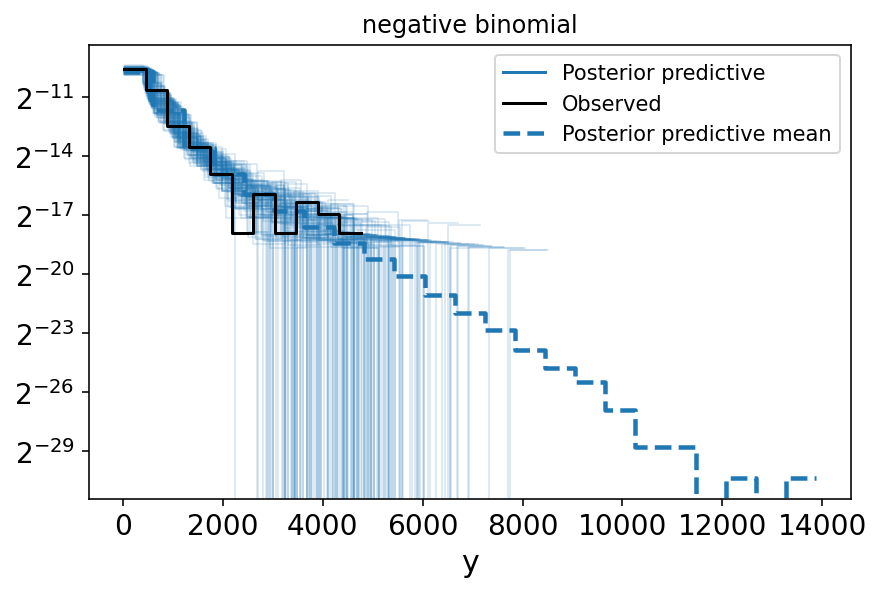

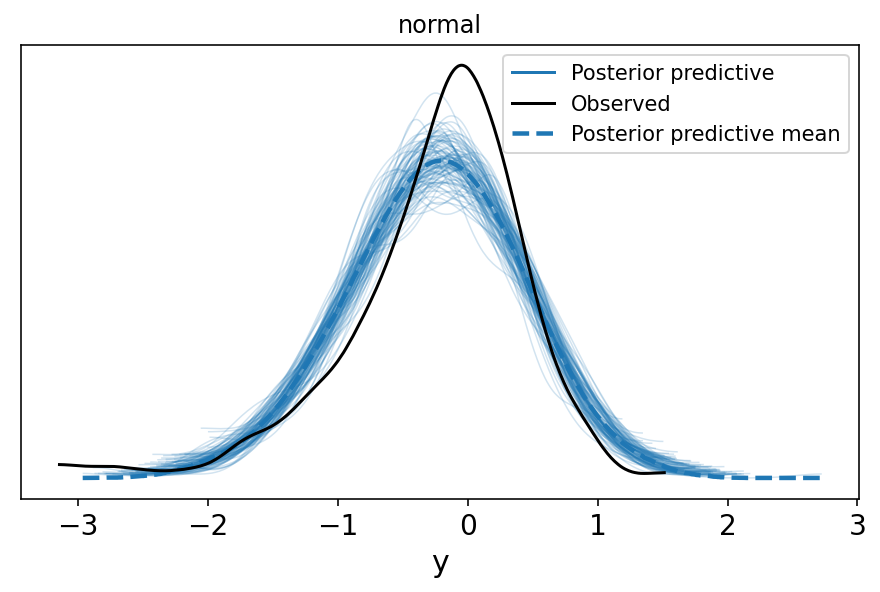

In [53]:
for name, idata in model_collection.items():
    ax = az.plot_ppc(idata, num_pp_samples=100, random_seed=RANDOM_SEED)
    ax.set_title(name)
    if "binomial" in name:
        ax.set_yscale("log", base=2)
    plt.show()

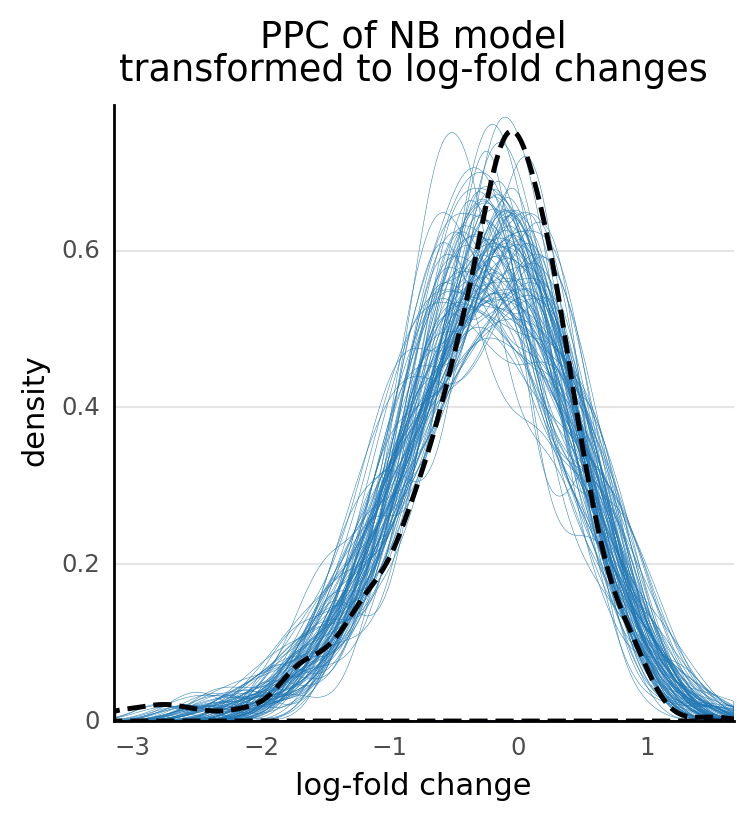

<ggplot: (364743105)>

In [148]:
nb_lfc_ppc_sample, _ = pmanal.down_sample_ppc(
    pmhelp.thin_posterior(
        nb_trace["posterior_predictive"]["lfc"], thin_to=100
    ).values.squeeze(),
    n=100,
    axis=1,
)

nb_ppc_lfc_sample_df = pd.DataFrame(nb_lfc_ppc_sample.T).pivot_longer(
    names_to="ppc_idx", values_to="draw"
)

(
    gg.ggplot(nb_ppc_lfc_sample_df, gg.aes(x="draw"))
    + gg.geom_density(gg.aes(group="ppc_idx"), weight=0.2, size=0.1, color="C0")
    + gg.geom_density(gg.aes(x="lfc"), data=data, color="k", size=1, linetype="--")
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(
        x="log-fold change",
        y="density",
        title="PPC of NB model\ntransformed to log-fold changes",
    )
)

In [41]:
def prep_ppc(name: str, idata: az.InferenceData, observed_y: str) -> pd.DataFrame:
    df = pmanal.summarize_posterior_predictions(
        idata["posterior_predictive"]["y"].values.squeeze(),
        merge_with=data[["hugo_symbol", "lfc", "counts_final", "counts_initial"]],
        calc_error=True,
        observed_y=observed_y,
    ).assign(
        model=name,
        percent_error=lambda d: 100 * (d[observed_y] - d.pred_mean) / d[observed_y],
        real_value=lambda d: d[observed_y],
    )

    if observed_y == "counts_final":
        df["pred_lfc"] = np.log2(df.pred_mean / df.counts_initial)
        df["pred_lfc_low"] = np.log2(df.pred_hdi_low / df.counts_initial)
        df["pred_lfc_high"] = np.log2(df.pred_hdi_high / df.counts_initial)
    else:
        df["pred_lfc"] = df.pred_mean
        df["pred_lfc_low"] = df.pred_hdi_low
        df["pred_lfc_high"] = df.pred_hdi_high

    df["lfc_error"] = df["lfc"] - df["pred_lfc"]

    return df


ppc_df = pd.concat(
    [
        prep_ppc(m[0], m[1], y)
        for m, y in zip(model_collection.items(), ("counts_final", "lfc"))
    ]
)
ppc_df.head()

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


pred_mean  pred_hdi_low  pred_hdi_high hugo_symbol       lfc  counts_final  \
0  290.51025         102.0          437.0      ACVR1C  0.296921         329.0   
1  423.19050         174.0          664.0      ACVR1C  0.944830         741.0   
2  583.94200         236.0          903.0      ACVR1C -0.646824         344.0   
3  317.03350         125.0          488.0      ACVR1C -0.016798         286.0   
4  379.92125         146.0          573.0      ACVR1C -0.074812         329.0   

   counts_initial      error              model  percent_error  real_value  \
0      267.802016   38.48975  negative binomial      11.699012       329.0   
1      384.942637  317.80950  negative binomial      42.889271       741.0   
2      538.606821 -239.94200  negative binomial     -69.750581       344.0   
3      289.349513  -31.03350  negative binomial     -10.850874       286.0   
4      346.510616  -50.92125  negative binomial     -15.477584       329.0   

   pred_lfc  pred_lfc_low  pred_lfc_high  lfc_error  
0  0.117422     -1.392598       0.706466   0.179499  
1  0.136664     -1.145556       0.786540   0.808166  
2  0.116593     -1.190446       0.745493  -0.763417  
3  0.131822     -1.210885       0.754068  -0.148620  
4  0.132801     -1.246931       0.725636  -0.207613

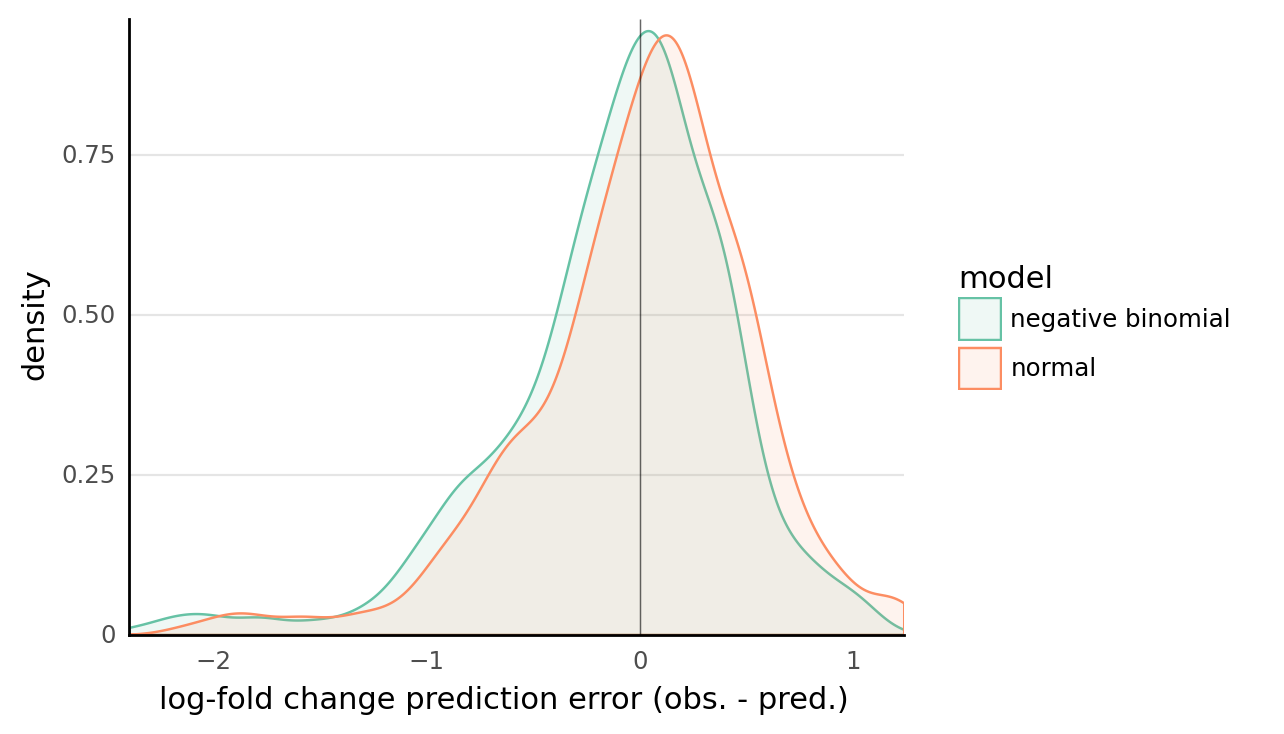

<ggplot: (353648083)>

In [42]:
(
    gg.ggplot(ppc_df, gg.aes(x="lfc_error"))
    + gg.geom_density(gg.aes(color="model", fill="model"), alpha=0.1)
    + gg.geom_vline(gg.aes(xintercept=0), alpha=0.6, size=0.3)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_color_brewer(type="qual", palette="Set2")
    + gg.scale_fill_brewer(type="qual", palette="Set2")
    + gg.theme(figure_size=(5, 4))
    + gg.labs(x="log-fold change prediction error (obs. - pred.)")
)

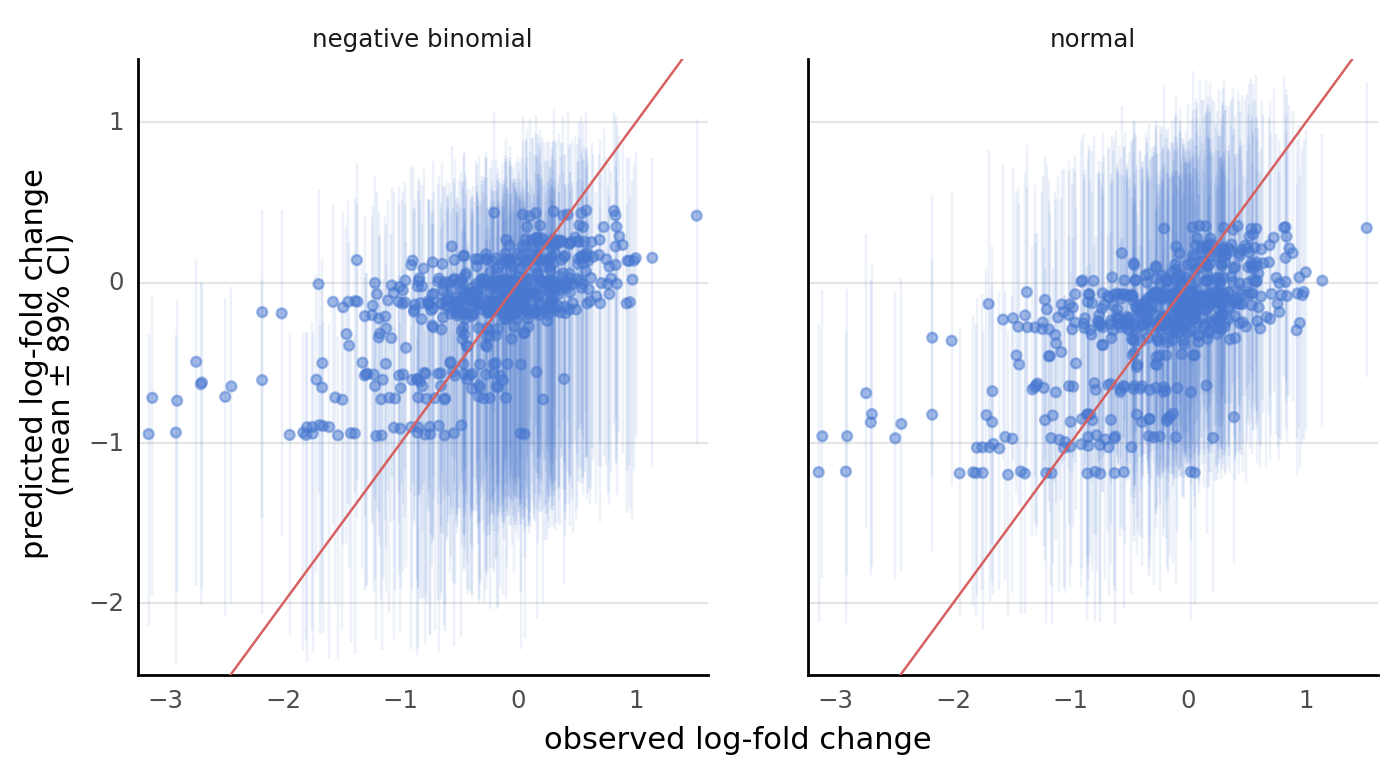

<ggplot: (353138815)>

In [43]:
(
    gg.ggplot(ppc_df, gg.aes(x="lfc", y="pred_lfc"))
    + gg.facet_wrap("~ model", nrow=1)
    + gg.geom_linerange(
        gg.aes(ymin="pred_lfc_low", ymax="pred_lfc_high"),
        alpha=0.1,
        size=0.5,
        color=SeabornColor.BLUE,
    )
    + gg.geom_point(alpha=0.5, color=SeabornColor.BLUE)
    + gg.geom_abline(slope=1, intercept=0, color=SeabornColor.RED)
    + gg.scale_x_continuous(expand=(0.02, 0, 0.02, 0))
    + gg.scale_y_continuous(expand=(0.02, 0, 0.02, 0))
    + gg.theme(figure_size=(8, 4), panel_spacing_x=0.5)
    + gg.labs(
        x="observed log-fold change", y="predicted log-fold change\n(mean ± 89% CI)"
    )
)

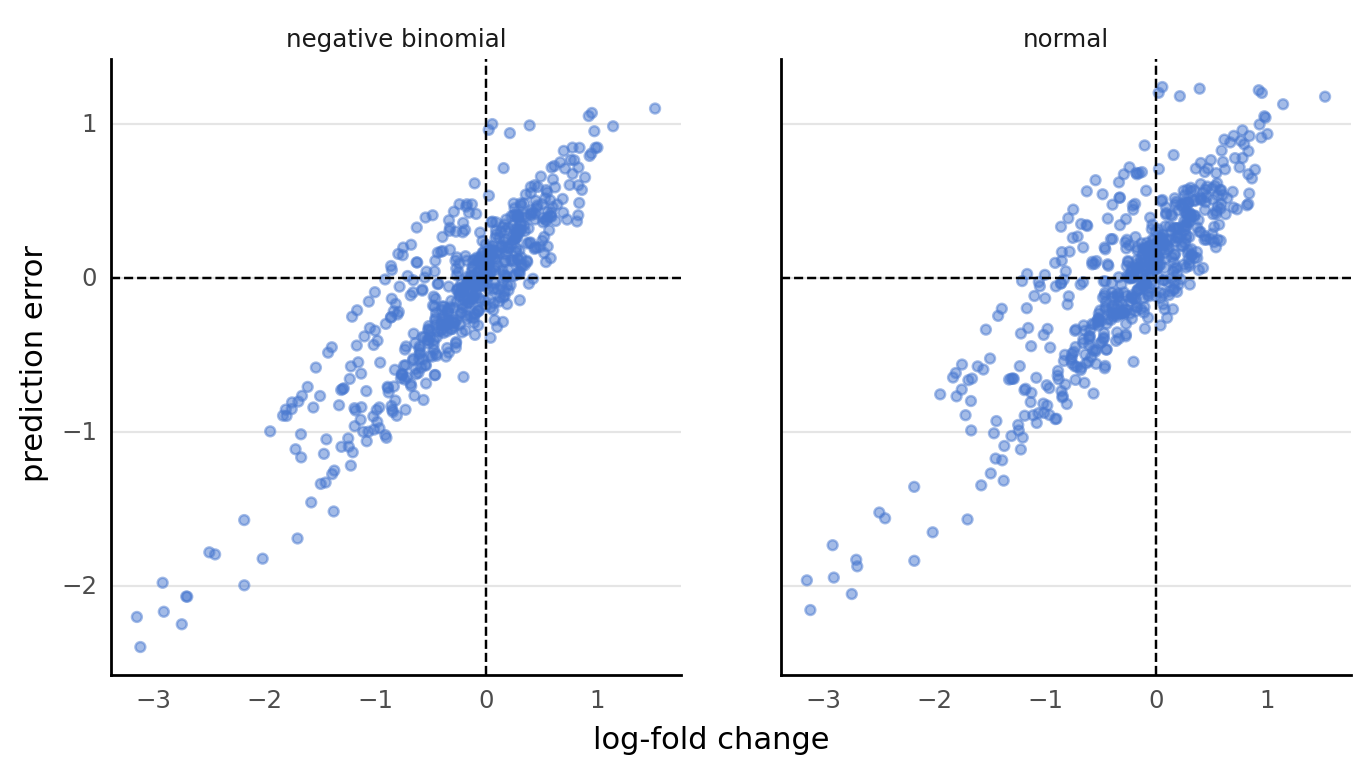

<ggplot: (353847760)>

In [44]:
(
    gg.ggplot(ppc_df, gg.aes(x="lfc", y="lfc_error"))
    + gg.facet_wrap("~ model", nrow=1)
    + gg.geom_point(alpha=0.5, color=SeabornColor.BLUE)
    + gg.geom_hline(yintercept=0, linetype="--")
    + gg.geom_vline(xintercept=0, linetype="--")
    + gg.theme(figure_size=(8, 4), panel_spacing_x=0.5)
    + gg.labs(x="log-fold change", y="prediction error")
)

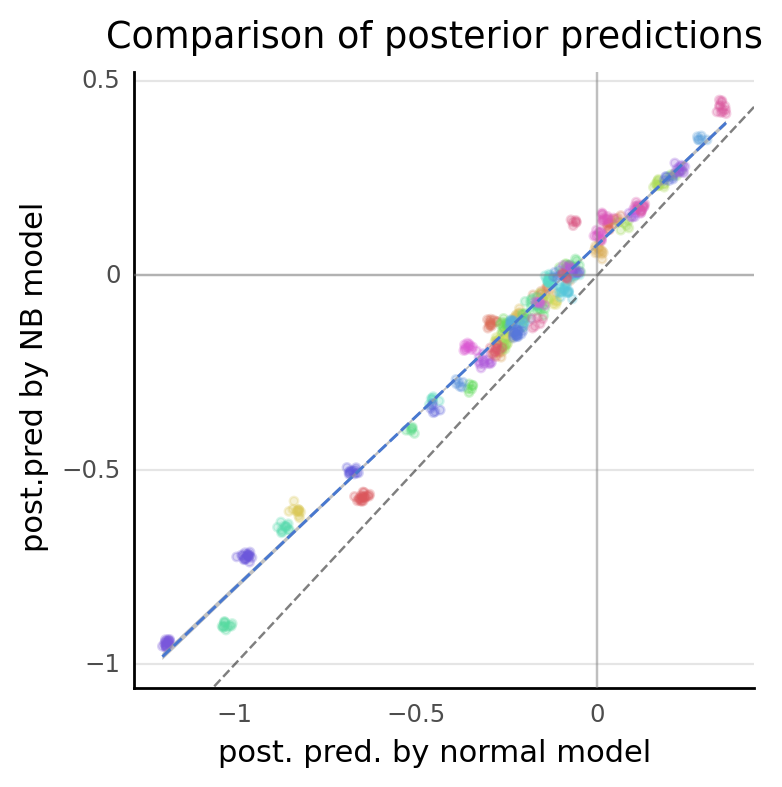

<ggplot: (353899852)>

In [45]:
(
    gg.ggplot(
        ppc_df[["model", "pred_lfc", "hugo_symbol"]]
        .pivot_wider(names_from="model", values_from="pred_lfc")
        .merge(data, left_index=True, right_index=True),
        gg.aes(x="normal", y="negative binomial"),
    )
    + gg.geom_point(
        gg.aes(color="hugo_symbol"), size=1.2, alpha=0.25, show_legend=False
    )
    + gg.geom_abline(slope=1, intercept=0, linetype="--", alpha=0.5)
    + gg.geom_smooth(
        method="lm",
        formula="y~x",
        alpha=0.6,
        linetype="--",
        size=0.6,
        color=SeabornColor.BLUE,
    )
    + gg.geom_hline(yintercept=0, alpha=0.5, color="grey")
    + gg.geom_vline(xintercept=0, alpha=0.5, color="grey")
    + gg.scale_color_hue()
    + gg.labs(
        x="post. pred. by normal model",
        y="post.pred by NB model",
        title="Comparison of posterior predictions",
    )
)

In [154]:
loo_collection = {n: az.loo(d, pointwise=True) for n, d in model_collection.items()}

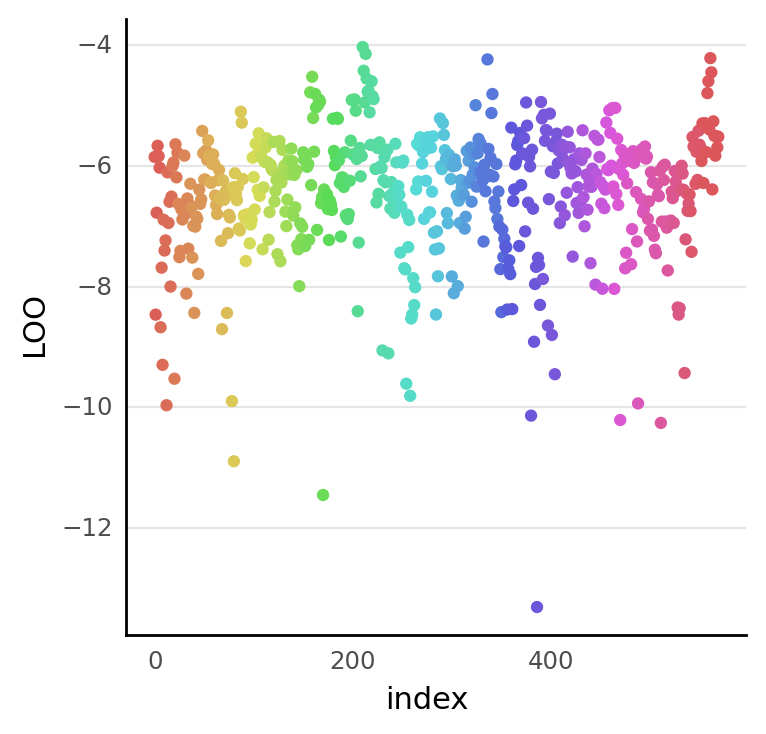

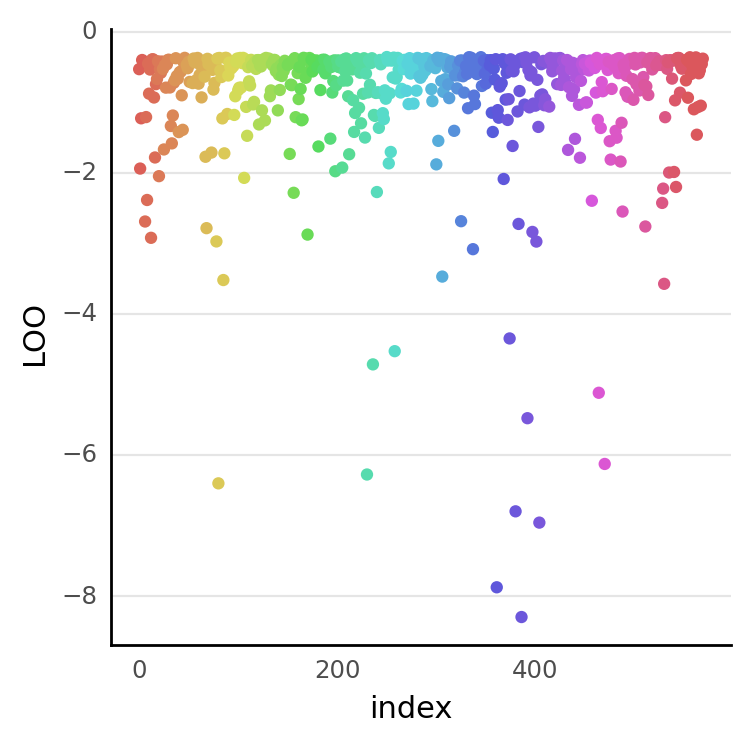

In [163]:
for name, loo_res in loo_collection.items():
    d = (
        pd.DataFrame({"hugo_symbol": data["hugo_symbol"], "loo": loo_res.loo_i})
        .sort_values("hugo_symbol")
        .reset_index(drop=False)
    )
    p = (
        gg.ggplot(d, gg.aes(x="index", y="loo"))
        + gg.geom_point(gg.aes(color="hugo_symbol"), show_legend=False)
        + gg.scale_color_hue()
        + gg.labs(x="index", y="LOO")
    )
    print(p)

---

In [29]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 9.98 minutes


In [30]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-09-20

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: nb-model

matplotlib: 3.4.3
seaborn   : 0.11.2
plotnine  : 0.8.0
re        : 2.2.1
logging   : 0.5.1.2
pandas    : 1.3.2
numpy     : 1.21.2
theano    : 1.0.5
arviz     : 0.11.2
pymc3     : 3.11.2

